### This notebook implements the C2FF method on the Botswana Hyperspectral Image

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
import os
from spectral import *
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchsummary
import torchprofile
from fvcore.nn import FlopCountAnalysis, parameter_count_table, parameter_count

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Defining each PSF

kernel_size = 7
sigma = 3.40

def gaussian_psf(sigma, psf_size):
    """Generate a Gaussian PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf = psf / psf.sum()
    return psf
gaus_psf = gaussian_psf(sigma, kernel_size)

def kolmogorov_psf(sigma, psf_size):
    """Generate a Kolmogorov PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-(r / sigma)**(5/3))
    psf = psf / psf.sum()
    return psf
kol_psf = kolmogorov_psf(sigma, kernel_size)

def airy_psf(sigma, psf_size):
    """Generate an Airy PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    z = (2.33811 * r) / sigma
    psf = (2 * kv(1, z) / z)**2
    psf[r == 0] = 1
    psf = psf / psf.sum()
    return psf
air_psf = airy_psf(sigma, kernel_size)

def moffat_psf(sigma, psf_size, beta=3.5):
    """Generate a Moffat PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = (1 + (r / sigma)**2)**(-beta)
    psf = psf / psf.sum()
    return psf
mof_psf = moffat_psf(sigma, kernel_size)

def sinc_psf(sigma, psf_size):
    """Generate a Sinc PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.sinc(r / sigma)
    psf = psf / psf.sum()
    return psf
sinc_psf = sinc_psf(sigma, kernel_size)

def lorentzian_squared_psf(sigma, psf_size):
    """Generate a Lorentzian Squared PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = 1 / (1 + (r / sigma)**4)
    psf = psf / psf.sum()
    return psf
lor_sq_psf = lorentzian_squared_psf(sigma, kernel_size)

def hermite_psf(sigma, psf_size, n=1):
    """Generate a Hermite PSF."""
    from numpy.polynomial.hermite import hermval
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-r**2 / (2 * sigma**2)) * hermval(r / sigma, [0]*n + [1])
    psf = psf / psf.sum()
    return psf
her_psf = hermite_psf(sigma, kernel_size)

def parabolic_psf(sigma, psf_size):
    """Generate a Parabolic PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.maximum(0, 1 - (r / sigma)**2)
    psf = psf / psf.sum()
    return psf
par_psf = parabolic_psf(sigma, kernel_size)

def gabor_psf(sigma, psf_size, theta=0, lambd=1, gamma=0.5, psi=0):
    """Generate a Gabor PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    x_theta = X * np.cos(theta) + Y * np.sin(theta)
    y_theta = -X * np.sin(theta) + Y * np.cos(theta)
    psf = np.exp(-0.5 * (x_theta**2 + gamma**2 * y_theta**2) / sigma**2) * np.cos(2 * np.pi * x_theta / lambd + psi)
    psf = psf / psf.sum()
    return psf
gab_psf = gabor_psf(sigma, kernel_size)

def delta_function_psf(sigma, psf_size):
    """Generate a Delta Function PSF."""
    psf = np.zeros((2*psf_size+1, 2*psf_size+1))
    psf[psf_size, psf_size] = 1
    return psf
delta_psf = delta_function_psf(sigma, kernel_size)

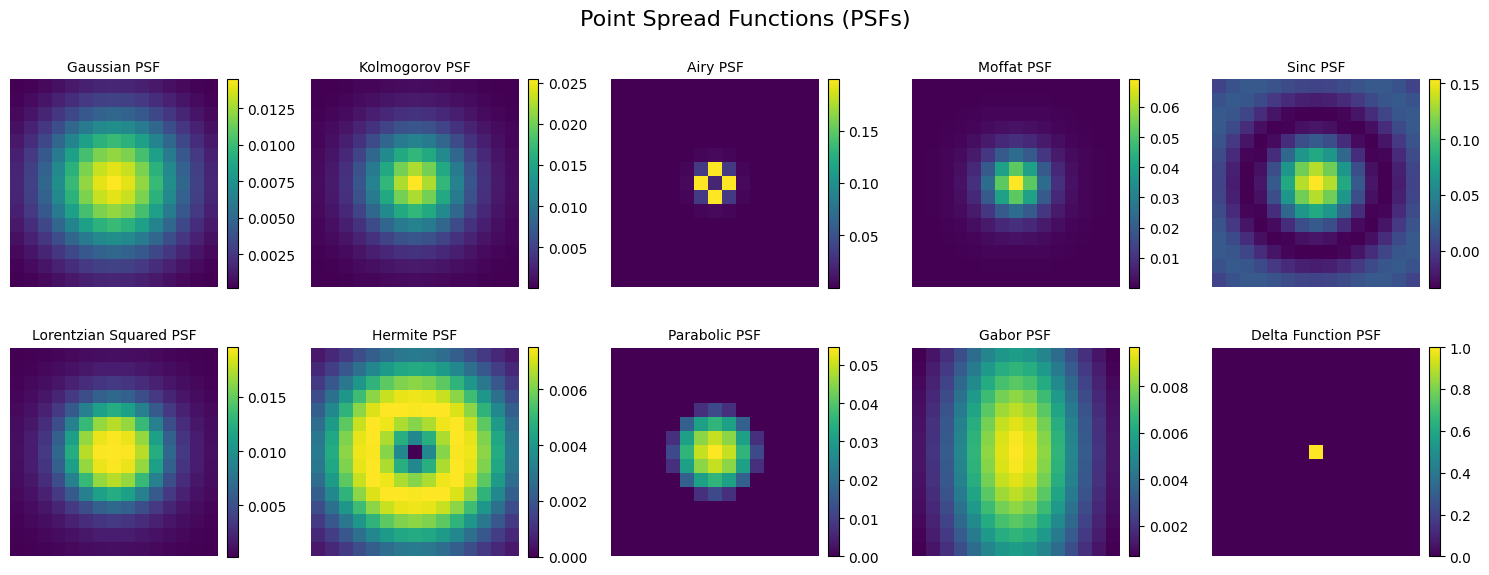

In [4]:
# Visualizing all the PSFs that will be used

psfs = [
    (gaus_psf, "Gaussian PSF"),
    (kol_psf, "Kolmogorov PSF"),
    (air_psf, "Airy PSF"),
    (mof_psf, "Moffat PSF"),
    (sinc_psf, "Sinc PSF"),
    (lor_sq_psf, "Lorentzian Squared PSF"),
    (her_psf, "Hermite PSF"),
    (par_psf, "Parabolic PSF"),
    (gab_psf, "Gabor PSF"),
    (delta_psf, "Delta Function PSF")
]

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 5 columns, 2 rows
fig.suptitle("Point Spread Functions (PSFs)", fontsize=16)

# Plot each PSF
for i, (psf, label) in enumerate(psfs):
    ax = axes[i // 5, i % 5]  # Determine subplot position
    im = ax.imshow(psf, cmap='viridis')
    ax.set_title(label, fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [5]:
# Function to apply PSF to an image
def apply_psf(image, psf):
    
    """
    Convolve each channel of 'image' with 'psf' using 'same' padding.

    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels).
    psf   : np.ndarray
        Shape (kernel_height, kernel_width).
        
    Returns:
    --------
    blurred_image : np.ndarray
        Same shape as input image (height, width, channels).
    """
    
    # Prepare an output array of the same shape as 'image'
    blurred_image = np.zeros_like(image, dtype=np.float32)

    # Convolve each channel separately
    channels = image.shape[2]
    for c in range(channels):
        # convolve2d with mode='same' replicates TensorFlow's 'SAME' padding
        blurred_image[:, :, c] = convolve2d(image[:, :, c], psf, mode='same')
        
    return blurred_image
    
# Function to downsample an image
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image
    
# Function to add noise to an image
def add_awgn_noise(hsi_image, SNR_dB):
    
    """
    Add AWGN (Additive White Gaussian Noise) to the input hsi_image,
    given a desired SNR in dB. Uses NumPy only.

    Parameters
    ----------
    hsi_image : np.ndarray
        Input image of shape (rows, cols, channels).
    SNR_dB : float
        Desired SNR in decibels.

    Returns
    -------
    noisy_hsi_image : np.ndarray
        Noisy image of the same shape as hsi_image.
    """

     # Ensure float32
    hsi_image = hsi_image.astype(np.float32)

    rows, cols, channels = hsi_image.shape

    # Compute the signal power for each channel
    # shape: (channels,)
    signal_power = np.mean(hsi_image ** 2, axis=(0, 1))

    # Convert SNR from dB to linear scale
    SNR_linear = 10 ** (SNR_dB / 10.0)

    # Compute noise power and noise standard deviation per channel
    noise_power = signal_power / SNR_linear  # shape: (channels,)
    noise_std = np.sqrt(noise_power)         # shape: (channels,)

    # Reshape for broadcasting across (rows, cols)
    noise_std = noise_std.reshape((1, 1, channels))

    # Generate white Gaussian noise
    noise = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(rows, cols, channels)
    ).astype(np.float32)

    # Scale noise by the computed standard deviation
    noise *= noise_std

    # Add noise to the original image
    noisy_hsi_image = hsi_image + noise

    return noisy_hsi_image
    
# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

# Function to obtain the Spectral Response Function for spectral degradation
def get_srf_bands(num_bands: int) -> np.ndarray:
    """
    Return a (num_bands, 3) array of [center_nm, low_edge_nm, high_edge_nm]
    matching the specified 'num_bands' from {1,3,4,8,16}.
    
    1-band  => IKONOS Panchromatic
    3-bands => IKONOS RGB
    4-bands => IKONOS B, G, R, NIR
    8-bands => WorldView-2 
    16-bands => WorldView-3

    Raises ValueError if num_bands is not in [1,3,4,8,16].
    """

    if num_bands == 1:
        # IKONOS panchromatic
        band_specs = np.array([
            [729.0, 409.0, 1048.0]  # center, lower, upper
        ], dtype=np.float32)
    
    elif num_bands == 3:
        # IKONOS RGB
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)
    
    elif num_bands == 4:
        # IKONOS B, G, R, NIR
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
            [803.0, 713.0, 893.0],  # NIR
        ], dtype=np.float32)

    elif num_bands == 8:
        # WorldView-2
        band_specs = np.array([
            [427.0, 396.0, 458.0],  # Coastal Blue
            [478.0, 442.0, 515.0],  # Blue
            [546.0, 506.0, 586.0],  # Green
            [608.0, 584.0, 632.0],  # Yellow
            [659.0, 624.0, 694.0],  # Red
            [724.0, 699.0, 749.0],  # Red Edge
            [833.0, 765.0, 901.0],  # NIR1
            [949.0, 856.0, 1043.0], # NIR2
        ], dtype=np.float32)
    
    elif num_bands == 16:
        # WorldView-3
        band_specs = np.array([
            [426.0, 397.0, 454.0],    # Coastal Blue
            [481.0, 445.0, 517.0],    # Blue
            [547.0, 507.0, 586.0],    # Green
            [605.0, 580.0, 629.0],    # Yellow
            [661.0, 626.0, 696.0],    # Red
            [724.0, 698.0, 749.0],    # Red Edge
            [832.0, 765.0, 899.0],    # NIR1
            [948.0, 857.0, 1039.0],   # NIR2
            [1210.0, 1184.0, 1235.0], # SWIR1
            [1572.0, 1546.0, 1598.0], # SWIR2
            [1661.0, 1636.0, 1686.0], # SWIR3
            [1730.0, 1702.0, 1759.0], # SWIR4
            [2164.0, 2137.0, 2191.0], # SWIR5
            [2203.0, 2174.0, 2232.0], # SWIR6
            [2260.0, 2228.0, 2292.0], # SWIR7
            [2329.0, 2285.0, 2373.0], # SWIR8
        ], dtype=np.float32)
    
    else:
        raise ValueError(f"Unsupported num_bands={num_bands}. Must be 1,3,4,8, or 16.")

    return band_specs
    
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
        Examples: 
            - 1-band IKONOS Panchromatic 
            - 3-band IKONOS RGB 
            - 4-band IKONOS (B,G,R,NIR) 
            - 8-band WorldView-2 
            - 16-band WorldView-3
        etc.
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [6]:
# Function to visualize an HSI
def visualize_hsi(img, bands, title):
    """
    Visualize a hyperspectral image by converting it to an RGB representation.
    
    Parameters:
    -----------
    img : np.ndarray
        Hyperspectral image array.
    bands : tuple
        Band indices to use for RGB representation.
    title : str
        Title for the plot.
    """
    img_rgb = get_rgb(img, bands)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('on')
    plt.show()

# Function to visualize an MSI/RGB/Panchromatic image along with the SRF
def plot_multispectral_with_srf(ms_image, bands, title, srf, wavelengths, ikonos_bands):
    """
    Visualize a multispectral (or RGB/panchromatic) image alongside its Spectral Response Function (SRF).
    
    Parameters
    ----------
    ms_image : np.ndarray
        Multispectral image, shape: (rows, cols, num_bands).
    bands : tuple
        Band indices to use for RGB representation (only used if num_bands >= 3).
    title : str
        Title for the image plot.
    srf : np.ndarray
        Spectral Response Function, shape: (num_bands, L).
    wavelengths : np.ndarray
        Wavelengths corresponding to the L hyperspectral bands (x-axis for SRF).
    ikonos_bands : np.ndarray
        An array with shape (num_bands, 3) containing [center_nm, low_edge_nm, high_edge_nm]
        for each band. It is used here just to show the center wavelength in the legend.
    
    Notes
    -----
    - This function assumes num_bands is one of {1,3,4,8,16}.
    - If num_bands=1, we skip get_rgb and just display a grayscale single-band image.
    - If num_bands=3,4,8,16, we attempt to display an RGB image using 'bands' for the channel ordering.
    - The SRF curve colors and labels are chosen via if/elif blocks, 
      matching each possible number of bands.
    """
    num_bands = ms_image.shape[2]  # e.g. 1,3,4,8,16

    # 1) Choose band labels & colors depending on how many bands we have
    if num_bands == 1:
        band_labels = ["Panchromatic"]
        band_colors = ["k"]
    elif num_bands == 3:
        band_labels = ["Blue", "Green", "Red"]
        band_colors = ["b", "g", "r"]
    elif num_bands == 4:
        band_labels = ["Blue", "Green", "Red", "NIR"]
        band_colors = ["b", "g", "r", "k"]
    elif num_bands == 8:
        band_labels = ["Coastal", "Blue", "Green", "Yellow", 
                       "Red", "Red Edge", "NIR1", "NIR2"]
        # You can pick any 8 distinct colors you like:
        band_colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]
    elif num_bands == 16:
        band_labels = [
            "Coastal Blue", "Blue", "Green", "Yellow", 
            "Red", "Red Edge", "NIR1", "NIR2",
            "SWIR1", "SWIR2", "SWIR3", "SWIR4",
            "SWIR5", "SWIR6", "SWIR7", "SWIR8"
        ]
        # Again, pick any 16 distinct colors you like:
        band_colors = [
            "b", "g", "r", "c", "m", "y", "k", "orange", 
            "purple", "brown", "pink", "gray", 
            "olive", "navy", "teal", "maroon"
        ]
    else:
        raise ValueError("Function only supports images with 1, 3, 4, 8, or 16 bands.")
    
    # 2) Create the figure with 2 subplots (image on the left, SRF on the right)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # 3) Plot the image
    if num_bands == 1:
        # Just display the single-band image in grayscale
        single_band_2d = ms_image[:, :, 0]  # shape (rows, cols)
        axs[0].imshow(single_band_2d, cmap="gray")
        axs[0].set_title(title + " (Single-Band/Panchromatic)")
    else:
        # We have at least 3 bands, so let's form an RGB image
        img_rgb = get_rgb(ms_image, bands)
        axs[0].imshow(img_rgb)
        axs[0].set_title(title)
    axs[0].axis('off')
    
    # 4) Plot the SRF curves in the second subplot
    for i in range(num_bands):
        center_nm = ikonos_bands[i, 0]  # The 'center' column from your band_specs
        axs[1].plot(
            wavelengths,
            srf[i, :],
            label=f'{band_labels[i]} (Center: {center_nm} nm)',
            color=band_colors[i]
        )
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Spectral Response')
    axs[1].set_title('Spectral Response Functions (SRF)')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
# Function to plot the spectra at input pixels  
def plot_spectra(ground_truth_hsi, super_resolved_hsi, x, y):
    """
    Plotting the spectra of two hyperspectral images at a specific pixel location.
    
    Inputs:
    ground_truth_hsi (numpy.ndarray): The ground truth hyperspectral image
    super_resolved_hsi (numpy.ndarray): The super resolved hyperspectral image (output of model)
    x (int): The x pixel location
    y (int): The y pixel location
    """
    
    ground_truth_hsi = ground_truth_hsi.astype(np.float32)
    super_resolved_hsi = super_resolved_hsi.astype(np.float32)
    
    # Extract the spectra at the specific pixel location (x,y)
    ground_truth_spectra = ground_truth_hsi[y, x, :]
    super_resolved_spectra = super_resolved_hsi[y, x, :]
    
    # Number of spectral bands
    num_bands = ground_truth_hsi.shape[2]
    print("Number of bands = ", num_bands)
    
    # Plot the spectra
    plt.figure(figsize=(10,5))
    plt.plot(range(num_bands), ground_truth_spectra, label='Ground Truth Spectra')
    plt.plot(range(num_bands), super_resolved_spectra, label='Super Resolved Spectra')
    
    # Add labels and title
    plt.xlabel('Spectral band')
    plt.ylabel('Reflectance')
    plt.title(f'Spectra at pixel location (x={x}, y={y})')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Synthetic input generation functions

In [7]:
# Function to spatially degrade an image
def spatial_degradation(image, psf, downsample_ratio, SNR):
    """
    Apply spatial degradation to an image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image.
    psf : np.ndarray
        Point Spread Function.
    downsample_ratio : int
        Factor by which to downsample.
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    
    Returns:
    --------
    degraded_image : np.ndarray
        Spatially degraded image.
    """
    I_HS = normalize(image)
    I_HS = apply_psf(I_HS, psf)
    I_HS = downsample_image(I_HS, downsample_ratio)
    I_HS = add_awgn_noise(I_HS, SNR)
    return I_HS

# Function to spectrally degrade an image
def spectral_degradation(image, SNR, num_bands=4, fwhm_factor=4.3):
    """
    Apply spectral degradation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Input HSI image, shape (rows, cols, L).
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    num_bands : int
        Desired number of output bands. Must be one of {1,3,4,8,16}.
        1 => IKONOS Panchromatic
        3 => IKONOS RGB
        4 => IKONOS B/G/R/NIR
        8 => WorldView-2
        16 => WorldView-3
    fwhm_factor : float
        Factor to approximate std dev from (upper_edge - lower_edge).
        Default=4.2 is typical for a rough Gaussian FWHM approximation.

    Returns
    -------
    I_MS : np.ndarray
        Spectrally degraded image of shape (rows, cols, num_bands).
    srf : np.ndarray
        The sensor SRF curves, shape (num_bands, L).
    band_specs : np.ndarray
        The band specs used, shape (num_bands, 3).
    auto_wavelengths : np.ndarray
        The automatically generated wavelengths, shape (L,).
    """
    
    # 1) Fetch the band specs for the desired sensor configuration
    band_specs = get_srf_bands(num_bands)

    # 2) Normalize the image to [0,1] (or however your normalize function works)
    I_MS = normalize(image)

    # 3) Apply the SRF to produce the 'multispectral' (or panchromatic/RGB) image
    I_MS, srf, auto_wavelengths = apply_srf(I_MS, band_specs, fwhm_factor=fwhm_factor)

    # 4) Add AWGN noise
    I_MS = add_awgn_noise(I_MS, SNR)

    # 5) Return the result plus info you might need for plotting or further usage
    return I_MS, srf, band_specs, auto_wavelengths

Importing and degrading the Botswana HSI

In [8]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Synthetic_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
mat_file_path = os.path.join(normalized_dataset_path, 'Botswana_data.mat')

Setting up and visualizing the ground truth and MSI, Pan, RGB images

Ground truth image shape:  (1476, 256, 145)


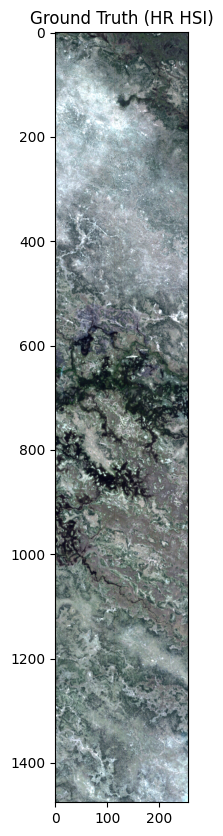

MSI shape:  (1476, 256, 1)


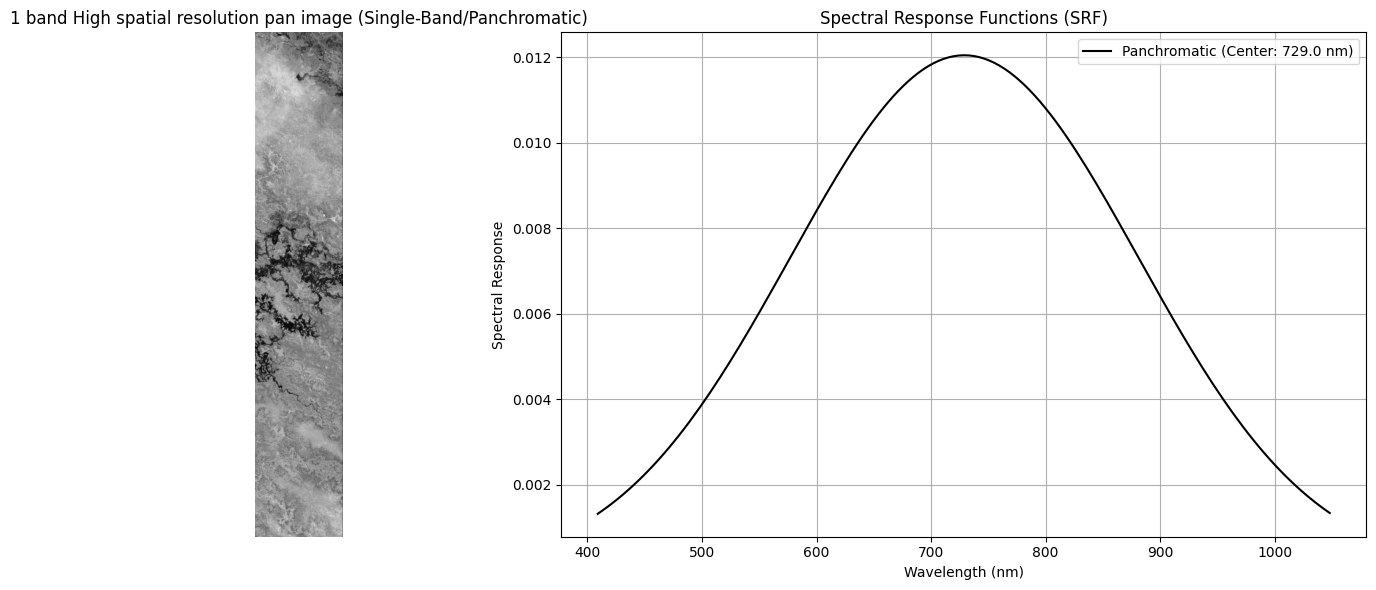

MSI shape:  (1476, 256, 3)


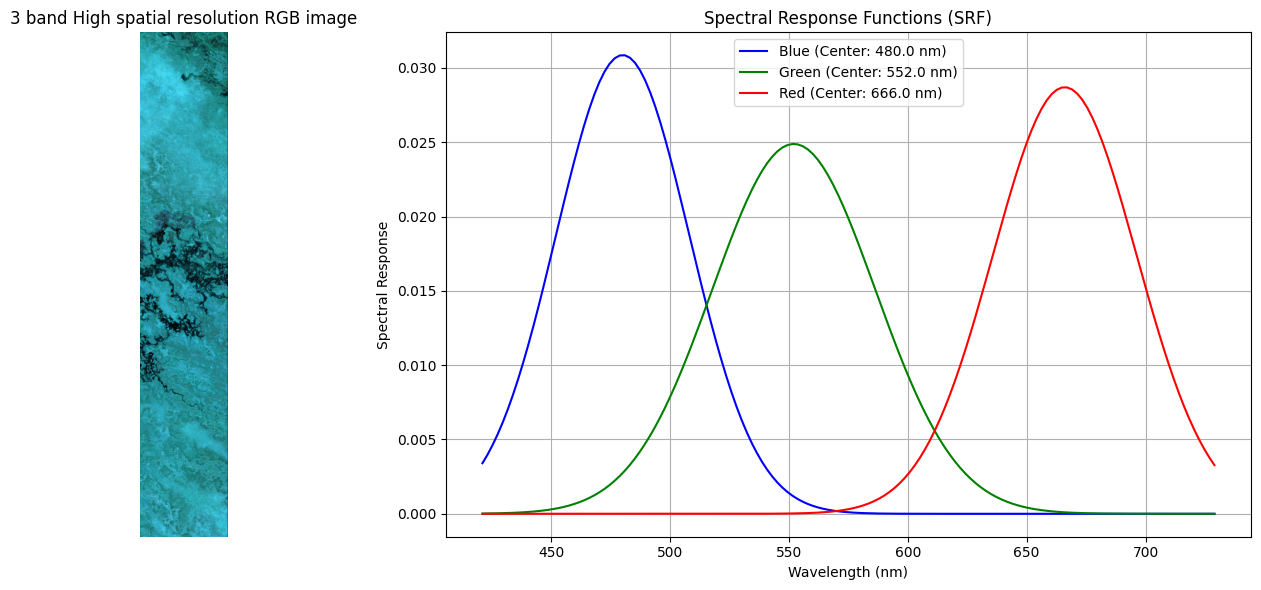

MSI shape:  (1476, 256, 4)


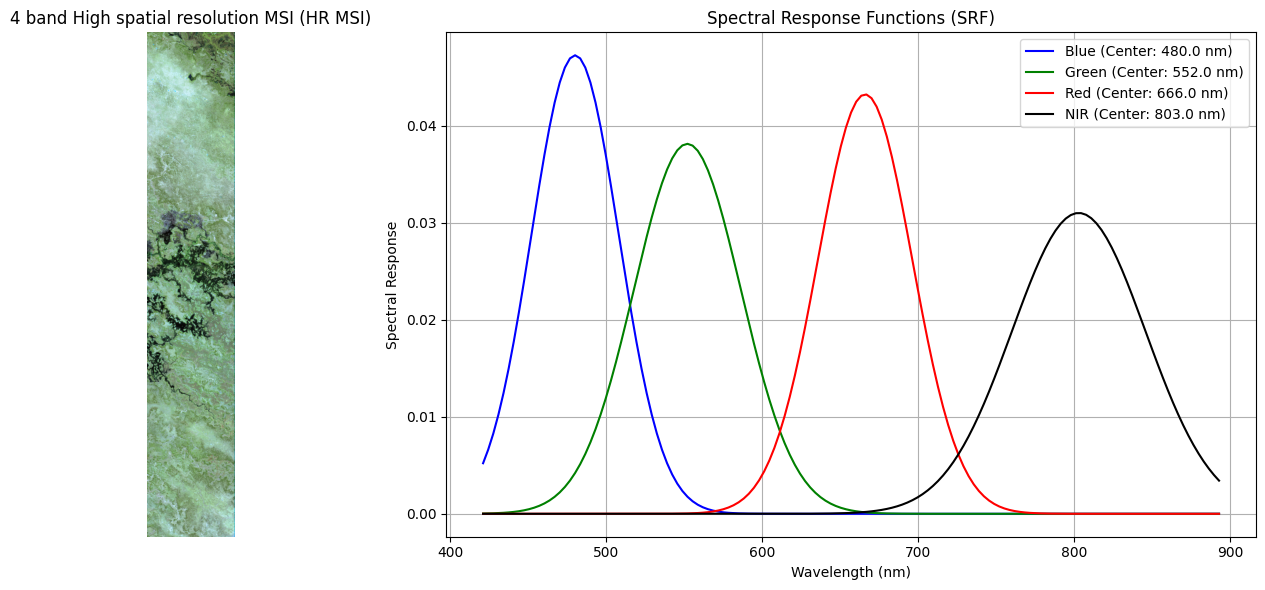

MSI shape:  (1476, 256, 8)


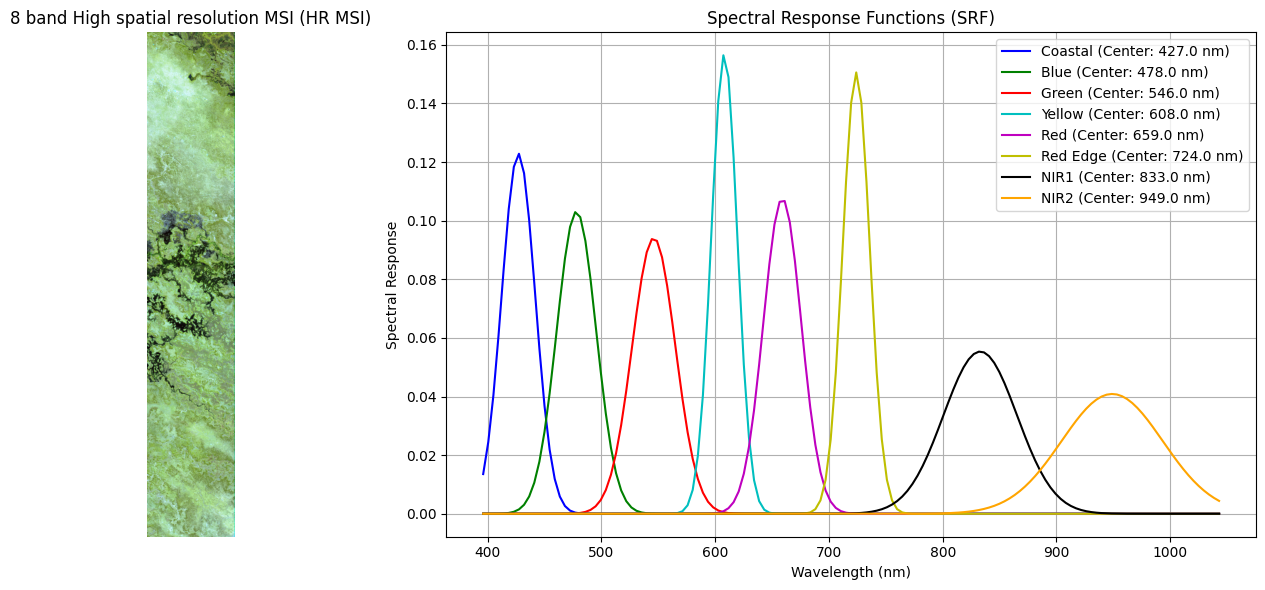

MSI shape:  (1476, 256, 16)


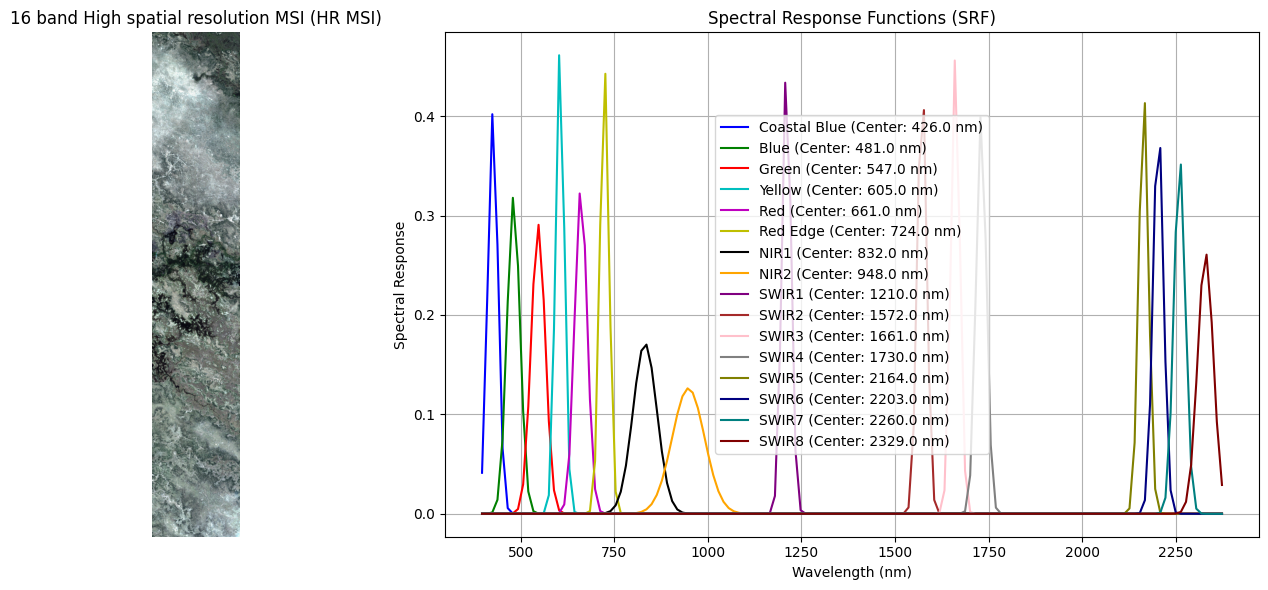

In [9]:
botswana = sio.loadmat(mat_file_path)
botswana_image = botswana['Botswana']

# Ground Truth HR HSI (H, W, C)
I_REF = normalize(botswana_image)
print("Ground truth image shape: ", I_REF.shape)
visualize_hsi(I_REF, (20, 9, 5), "Ground Truth (HR HSI)")

# High Resolution MSI with 1 band
I_MS_1, srf_1, band_specs_1, auto_wavs_1 = spectral_degradation(image=botswana_image, SNR=40, num_bands=1, fwhm_factor=4.2)
print("MSI shape: ", I_MS_1.shape)
plot_multispectral_with_srf(I_MS_1, None, "1 band High spatial resolution pan image", srf_1, auto_wavs_1, band_specs_1)

# High Resolution MSI with 3 bands
I_MS_3, srf_3, band_specs_3, auto_wavs_3 = spectral_degradation(image=botswana_image, SNR=40, num_bands=3, fwhm_factor=4.2)
print("MSI shape: ", I_MS_3.shape)
plot_multispectral_with_srf(I_MS_3, (2,1,0), "3 band High spatial resolution RGB image", srf_3, auto_wavs_3, band_specs_3)

# High Resolution MSI with 4 bands
I_MS_4, srf_4, band_specs_4, auto_wavs_4 = spectral_degradation(image=botswana_image, SNR=40, num_bands=4, fwhm_factor=4.2)
print("MSI shape: ", I_MS_4.shape)
plot_multispectral_with_srf(I_MS_4, (2,1,0), "4 band High spatial resolution MSI (HR MSI)", srf_4, auto_wavs_4, band_specs_4)

# High Resolution MSI with 8 bands
I_MS_8, srf_8, band_specs_8, auto_wavs_8 = spectral_degradation(image=botswana_image, SNR=40, num_bands=8, fwhm_factor=4.2)
print("MSI shape: ", I_MS_8.shape)
plot_multispectral_with_srf(I_MS_8, (4,2,1), "8 band High spatial resolution MSI (HR MSI)", srf_8, auto_wavs_8, band_specs_8)

# High Resolution MSI with 16 bands
I_MS_16, srf_16, band_specs_16, auto_wavs_16 = spectral_degradation(image=botswana_image, SNR=40, num_bands=16, fwhm_factor=4.2)
print("MSI shape: ", I_MS_16.shape)
plot_multispectral_with_srf(I_MS_16, (4,2,1), "16 band High spatial resolution MSI (HR MSI)", srf_16, auto_wavs_16, band_specs_16)

Setting up and visualizing the HSI images with Gaussian PSF

HSI shape with 4x Downsample:  (369, 64, 145)


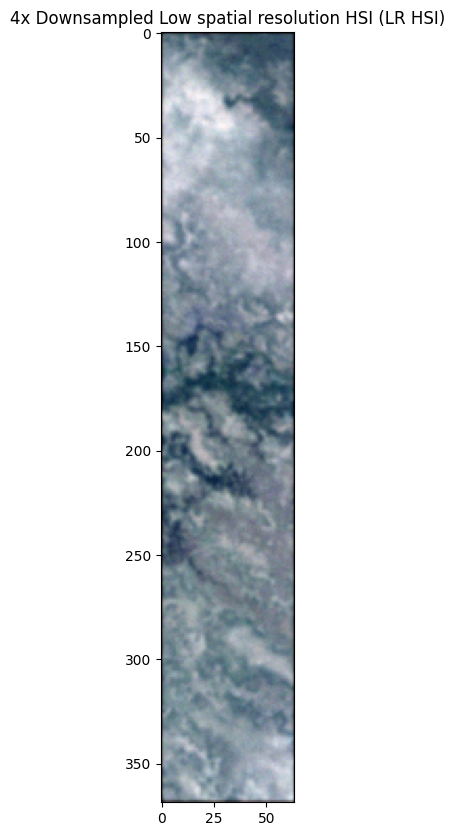

HSI shape with 8x Downsample:  (184, 32, 145)


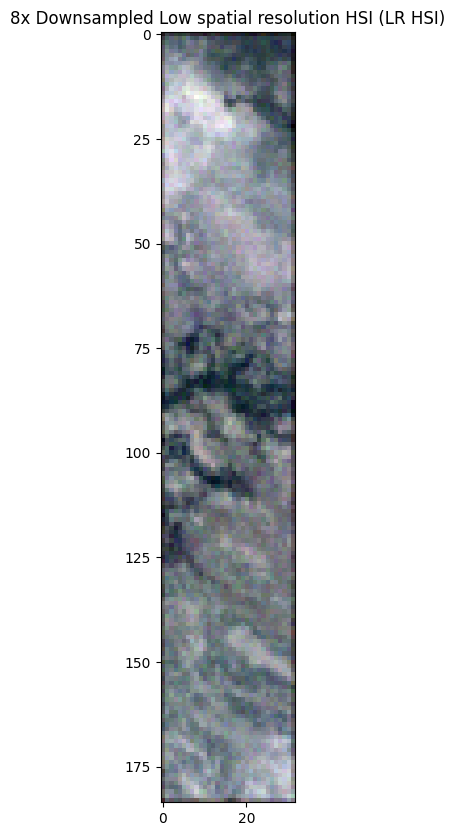

HSI shape with 16x Downsample:  (92, 16, 145)


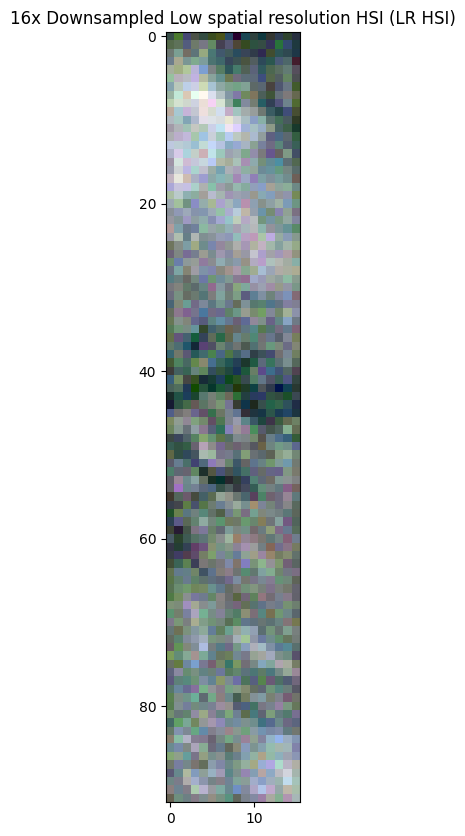

HSI shape with 32x Downsample:  (46, 8, 145)


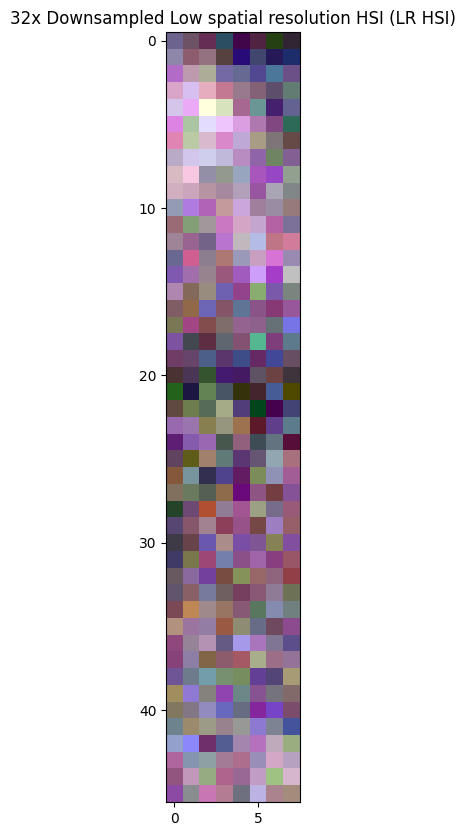

In [10]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gaus = spatial_degradation(botswana_image, gaus_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_gaus.shape)
visualize_hsi(I_HS_4_gaus, (20, 9, 5), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gaus = spatial_degradation(botswana_image, gaus_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_gaus.shape)
visualize_hsi(I_HS_8_gaus, (20, 9, 5), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gaus = spatial_degradation(botswana_image, gaus_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_gaus.shape)
visualize_hsi(I_HS_16_gaus, (20, 9, 5), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gaus = spatial_degradation(botswana_image, gaus_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_gaus.shape)
visualize_hsi(I_HS_32_gaus, (20, 9, 5), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Kolmogorov PSF

HSI shape with 4x Downsample:  (369, 64, 145)


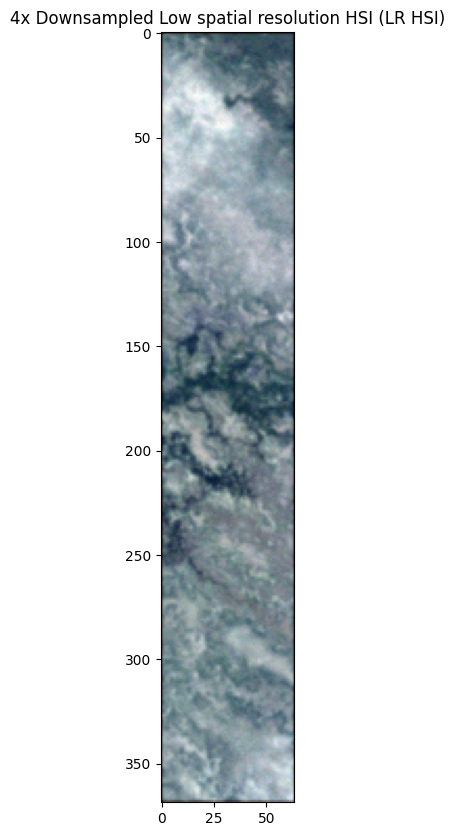

HSI shape with 8x Downsample:  (184, 32, 145)


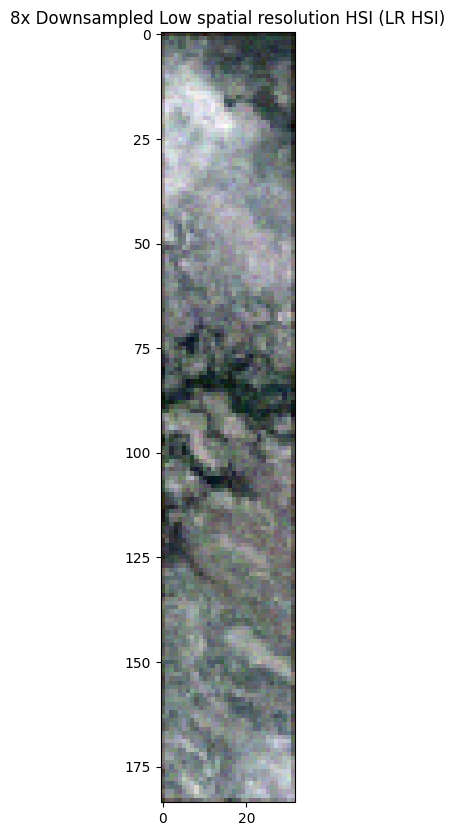

HSI shape with 16x Downsample:  (92, 16, 145)


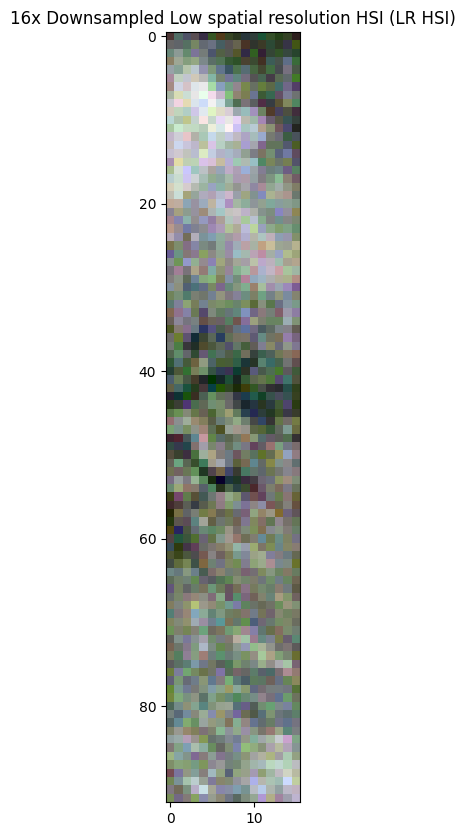

HSI shape with 32x Downsample:  (46, 8, 145)


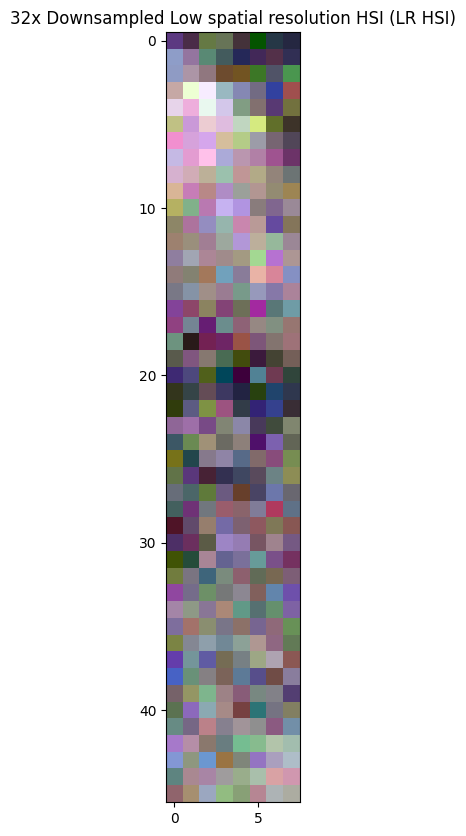

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_kol = spatial_degradation(botswana_image, kol_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_kol.shape)
visualize_hsi(I_HS_4_kol, (20, 9, 5), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_kol = spatial_degradation(botswana_image, kol_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_kol.shape)
visualize_hsi(I_HS_8_kol, (20, 9, 5), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_kol = spatial_degradation(botswana_image, kol_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_kol.shape)
visualize_hsi(I_HS_16_kol, (20, 9, 5), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_kol = spatial_degradation(botswana_image, kol_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_kol.shape)
visualize_hsi(I_HS_32_kol, (20, 9, 5), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Airy PSF

HSI shape with 4x Downsample:  (369, 64, 145)


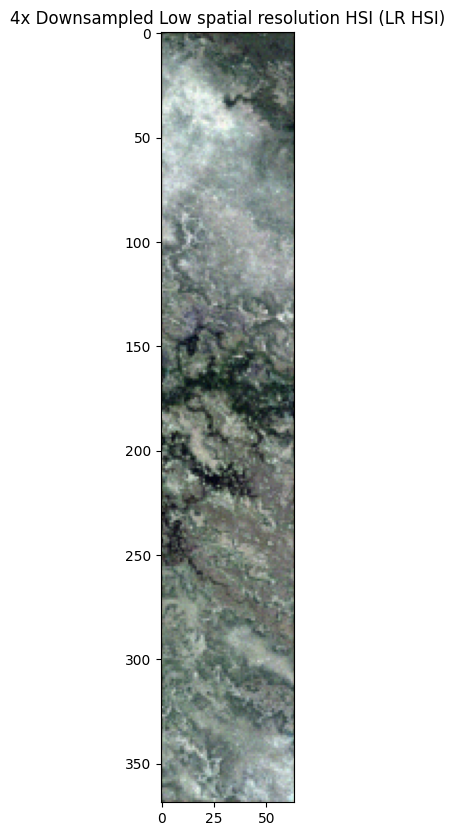

HSI shape with 8x Downsample:  (184, 32, 145)


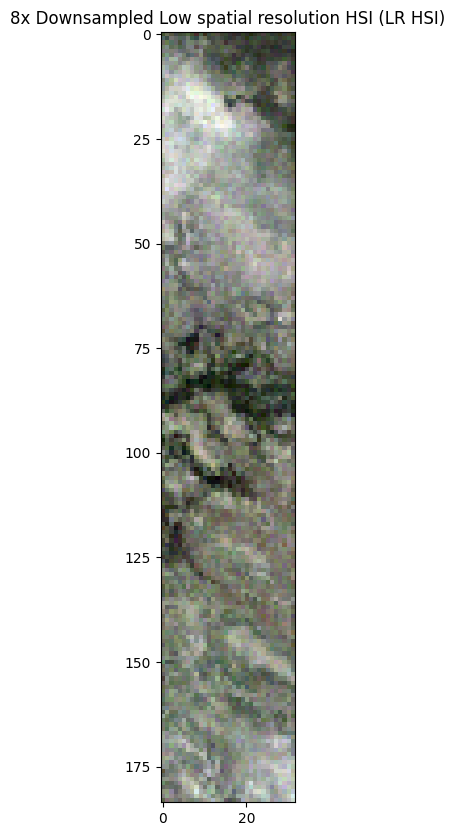

HSI shape with 16x Downsample:  (92, 16, 145)


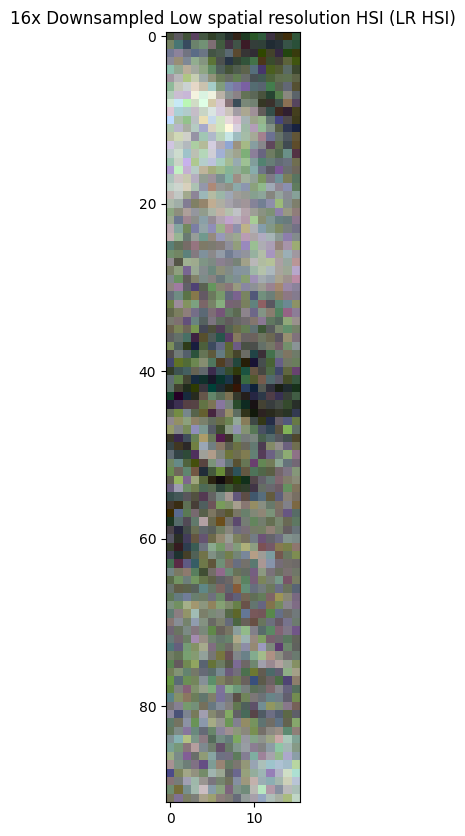

HSI shape with 32x Downsample:  (46, 8, 145)


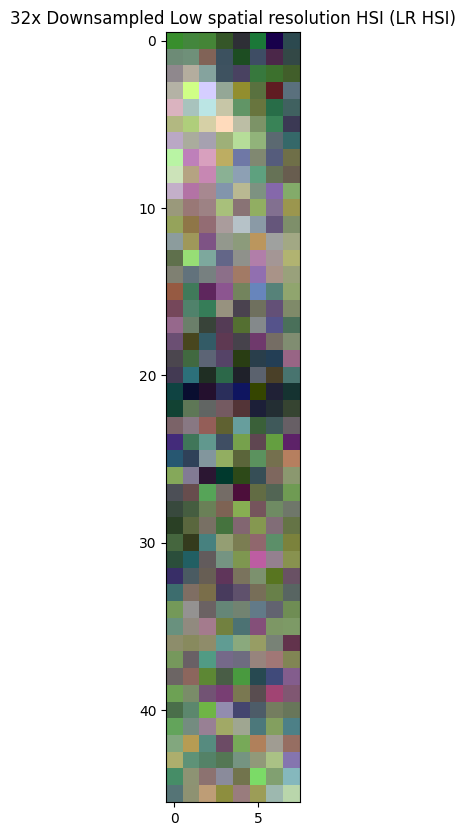

In [12]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_air = spatial_degradation(botswana_image, air_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_air.shape)
visualize_hsi(I_HS_4_air, (20, 9, 5), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_air = spatial_degradation(botswana_image, air_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_air.shape)
visualize_hsi(I_HS_8_air, (20, 9, 5), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_air = spatial_degradation(botswana_image, air_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_air.shape)
visualize_hsi(I_HS_16_air, (20, 9, 5), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_air = spatial_degradation(botswana_image, air_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_air.shape)
visualize_hsi(I_HS_32_air, (20, 9, 5), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Moffat PSF

HSI shape with 4x Downsample:  (369, 64, 145)


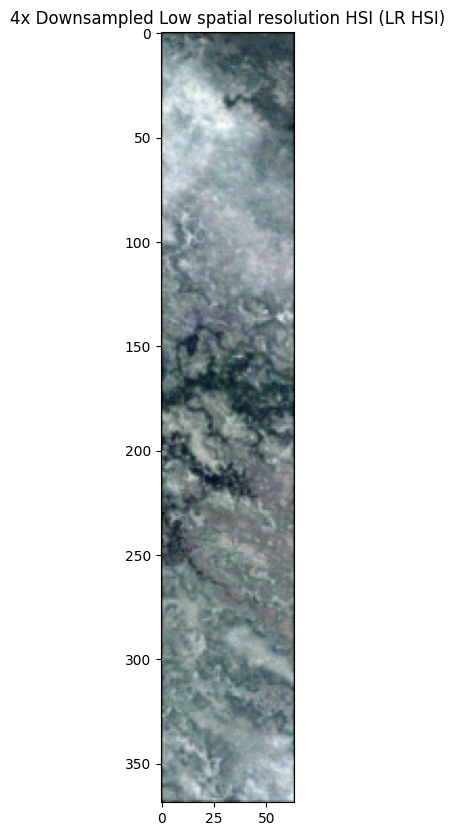

HSI shape with 8x Downsample:  (184, 32, 145)


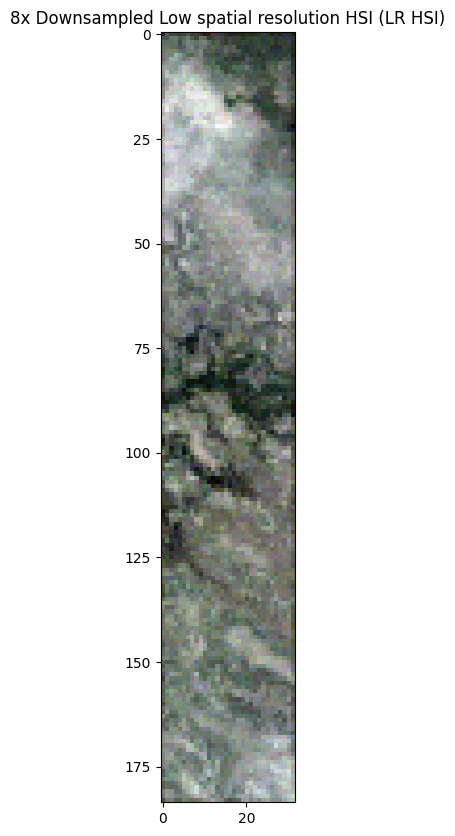

HSI shape with 16x Downsample:  (92, 16, 145)


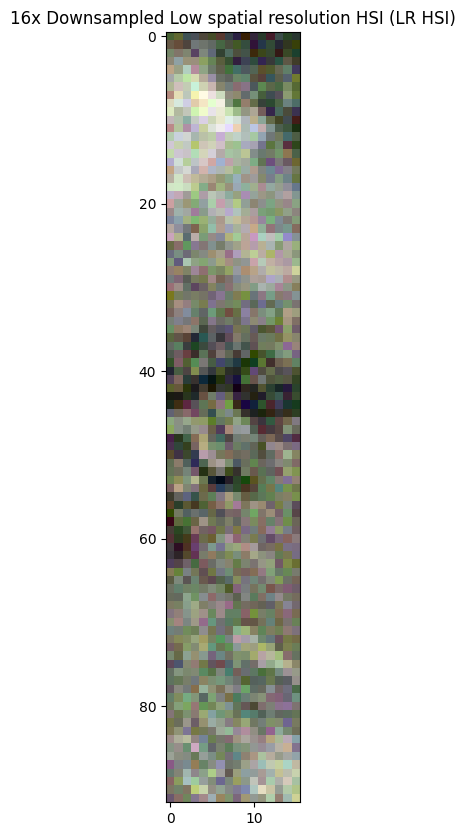

HSI shape with 32x Downsample:  (46, 8, 145)


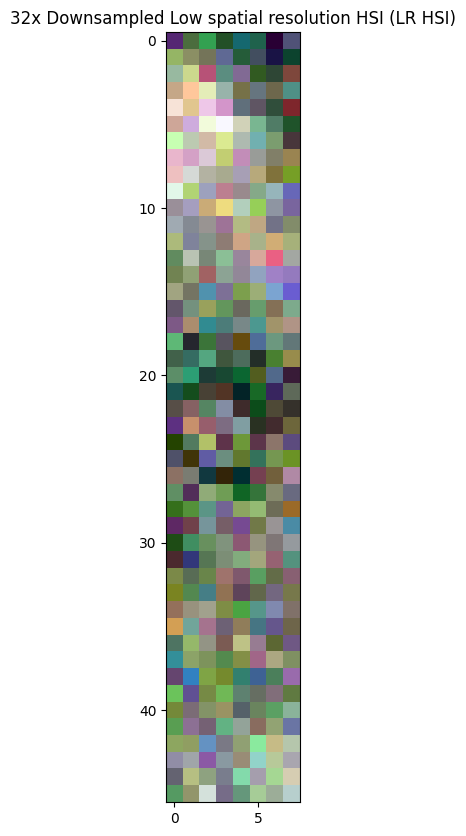

In [13]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_mof = spatial_degradation(botswana_image, mof_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_mof.shape)
visualize_hsi(I_HS_4_mof, (20, 9, 5), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_mof = spatial_degradation(botswana_image, mof_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_mof.shape)
visualize_hsi(I_HS_8_mof, (20, 9, 5), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_mof = spatial_degradation(botswana_image, mof_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_mof.shape)
visualize_hsi(I_HS_16_mof, (20, 9, 5), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_mof = spatial_degradation(botswana_image, mof_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_mof.shape)
visualize_hsi(I_HS_32_mof, (20, 9, 5), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Sinc PSF

HSI shape with 4x Downsample:  (369, 64, 145)


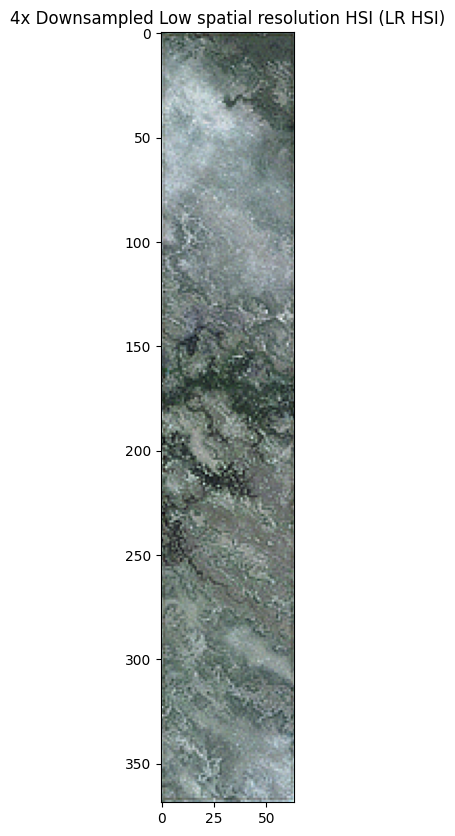

HSI shape with 8x Downsample:  (184, 32, 145)


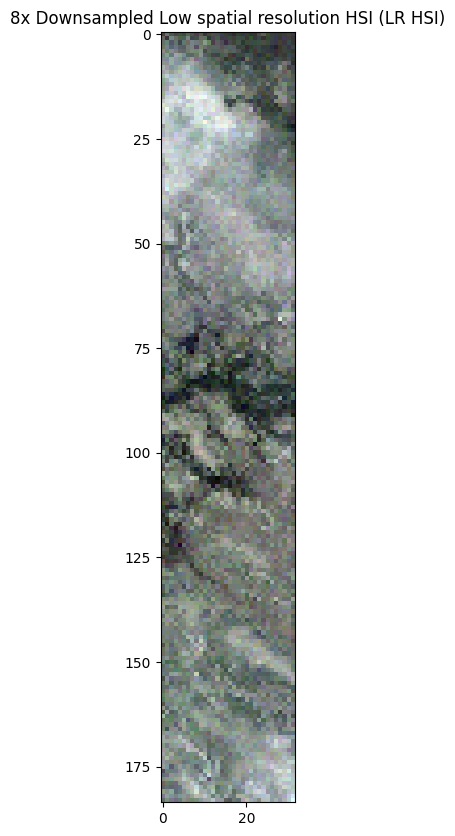

HSI shape with 16x Downsample:  (92, 16, 145)


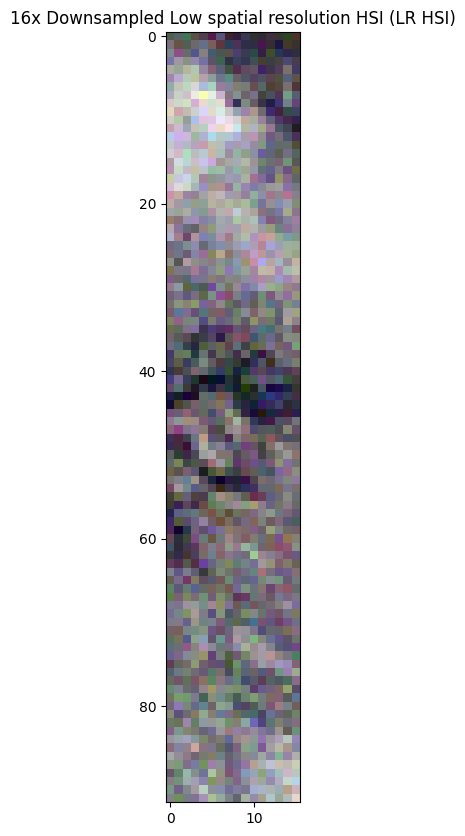

HSI shape with 32x Downsample:  (46, 8, 145)


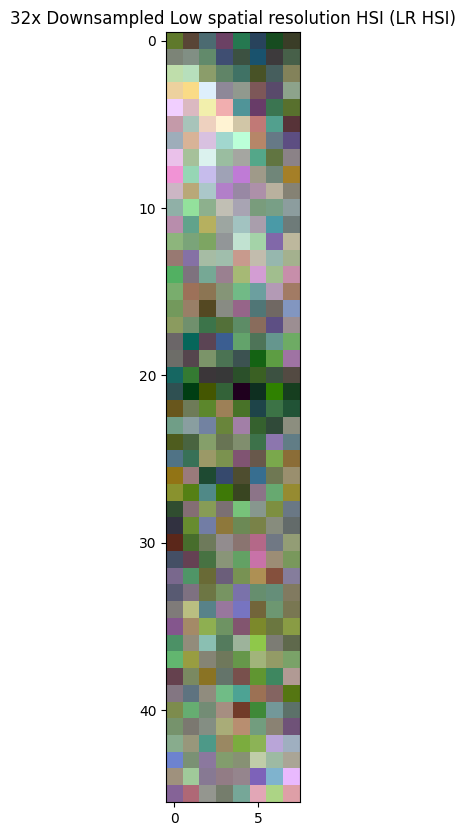

In [14]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_sinc = spatial_degradation(botswana_image, sinc_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_sinc.shape)
visualize_hsi(I_HS_4_sinc, (20, 9, 5), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_sinc = spatial_degradation(botswana_image, sinc_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_sinc.shape)
visualize_hsi(I_HS_8_sinc, (20, 9, 5), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_sinc = spatial_degradation(botswana_image, sinc_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_sinc.shape)
visualize_hsi(I_HS_16_sinc, (20, 9, 5), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_sinc = spatial_degradation(botswana_image, sinc_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_sinc.shape)
visualize_hsi(I_HS_32_sinc, (20, 9, 5), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Lorentzian Squared PSF

HSI shape with 4x Downsample:  (369, 64, 145)


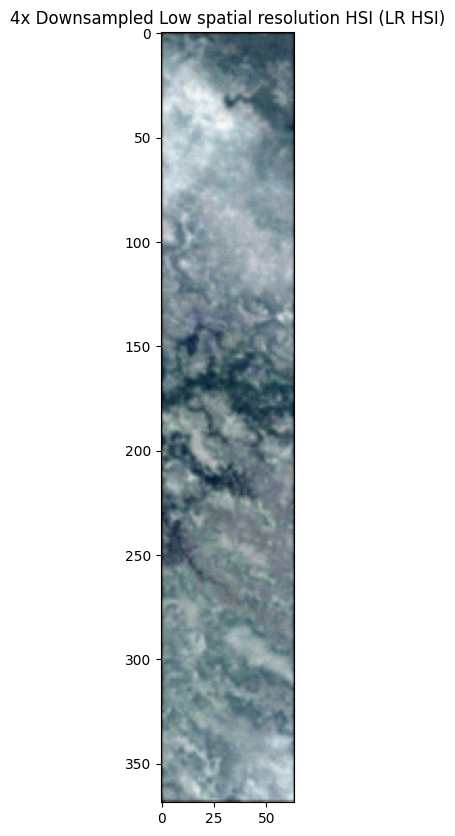

HSI shape with 8x Downsample:  (184, 32, 145)


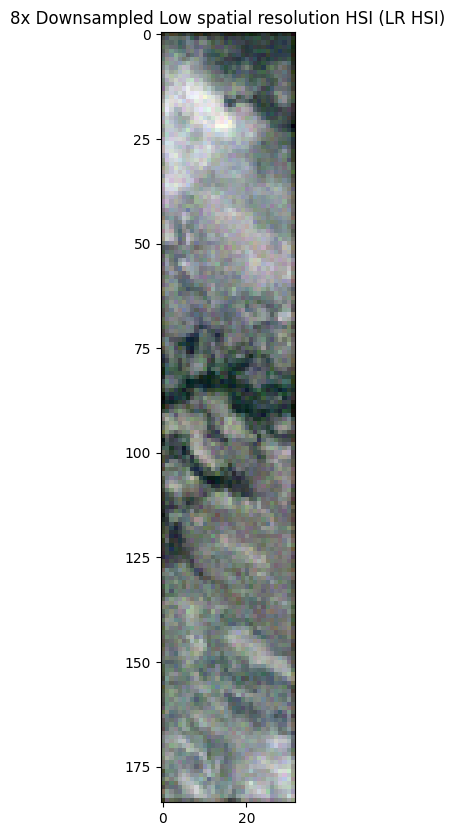

HSI shape with 16x Downsample:  (92, 16, 145)


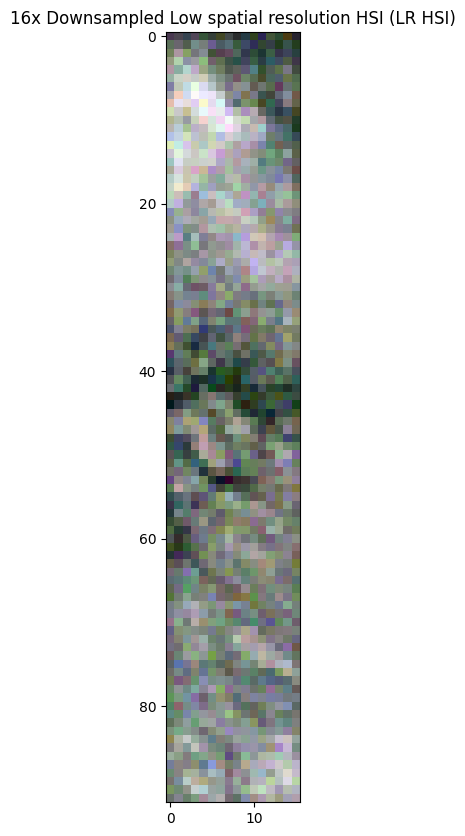

HSI shape with 32x Downsample:  (46, 8, 145)


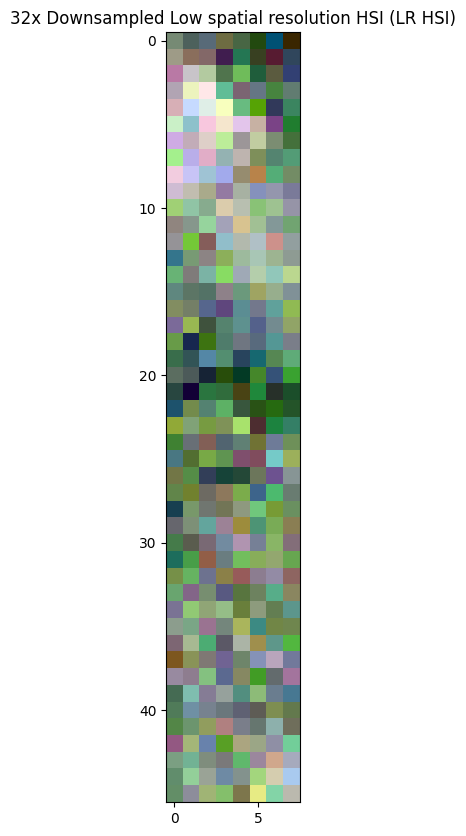

In [15]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_lor_sq = spatial_degradation(botswana_image, lor_sq_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_lor_sq.shape)
visualize_hsi(I_HS_4_lor_sq, (20, 9, 5), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_lor_sq = spatial_degradation(botswana_image, lor_sq_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_lor_sq.shape)
visualize_hsi(I_HS_8_lor_sq, (20, 9, 5), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_lor_sq = spatial_degradation(botswana_image, lor_sq_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_lor_sq.shape)
visualize_hsi(I_HS_16_lor_sq, (20, 9, 5), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_lor_sq = spatial_degradation(botswana_image, lor_sq_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_lor_sq.shape)
visualize_hsi(I_HS_32_lor_sq, (20, 9, 5), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Hermite PSF

HSI shape with 4x Downsample:  (369, 64, 145)


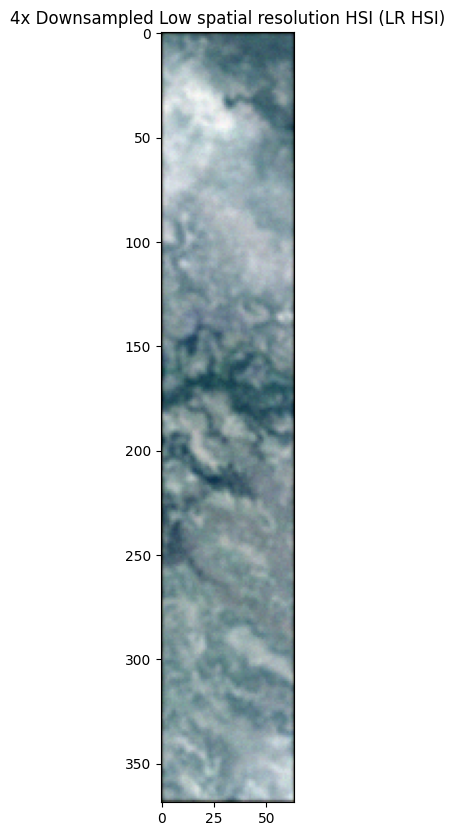

HSI shape with 8x Downsample:  (184, 32, 145)


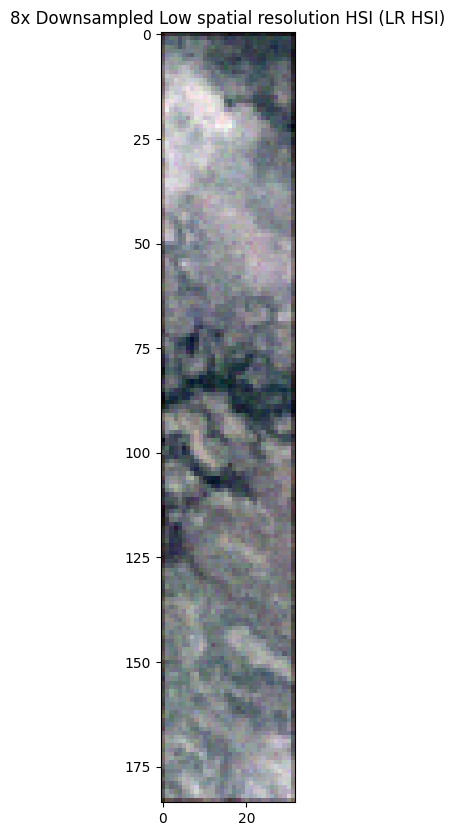

HSI shape with 16x Downsample:  (92, 16, 145)


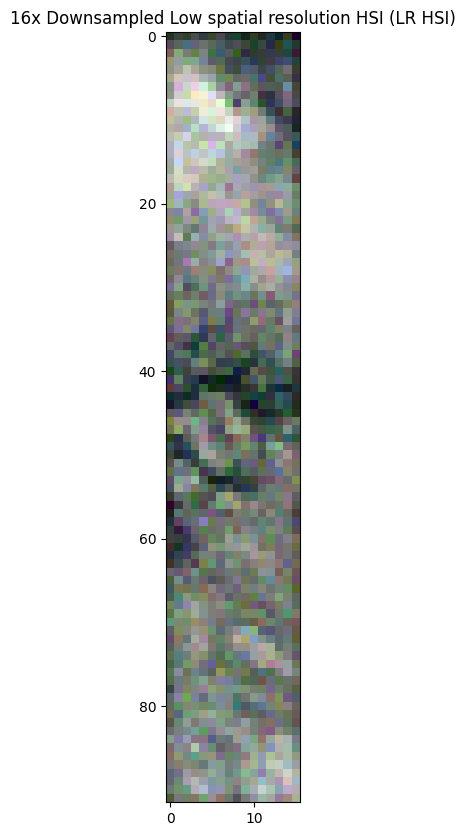

HSI shape with 32x Downsample:  (46, 8, 145)


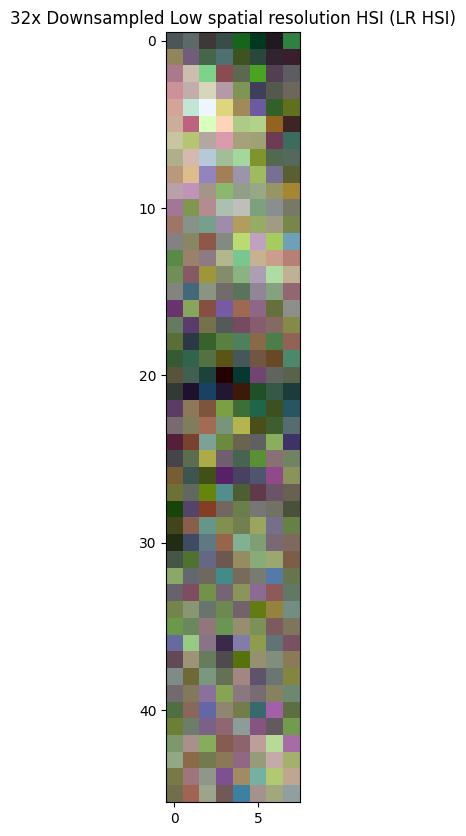

In [16]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_her = spatial_degradation(botswana_image, her_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_her.shape)
visualize_hsi(I_HS_4_her, (20, 9, 5), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_her = spatial_degradation(botswana_image, her_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_her.shape)
visualize_hsi(I_HS_8_her, (20, 9, 5), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_her = spatial_degradation(botswana_image, her_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_her.shape)
visualize_hsi(I_HS_16_her, (20, 9, 5), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_her = spatial_degradation(botswana_image, her_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_her.shape)
visualize_hsi(I_HS_32_her, (20, 9, 5), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Parabolic PSF

HSI shape with 4x Downsample:  (369, 64, 145)


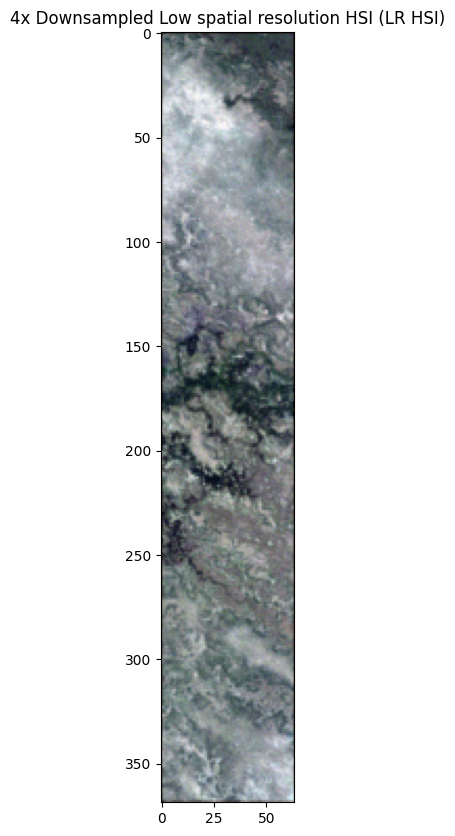

HSI shape with 8x Downsample:  (184, 32, 145)


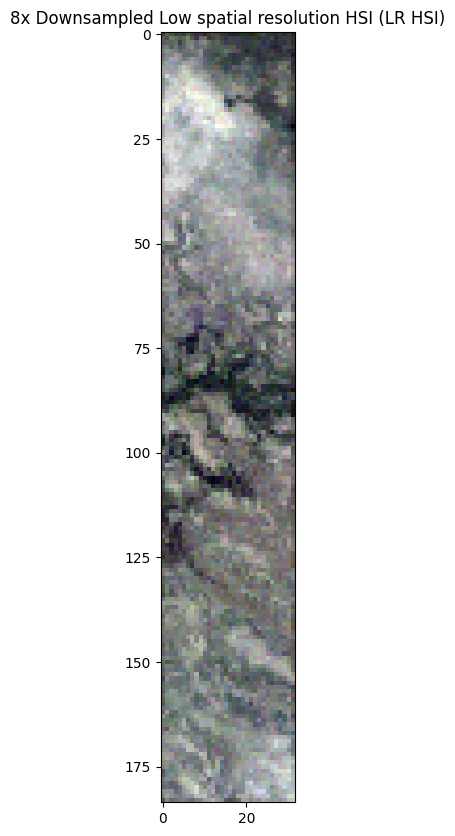

HSI shape with 16x Downsample:  (92, 16, 145)


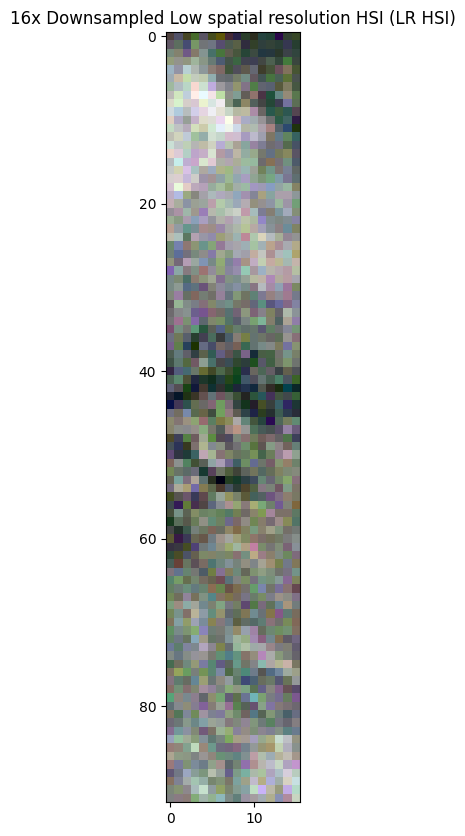

HSI shape with 32x Downsample:  (46, 8, 145)


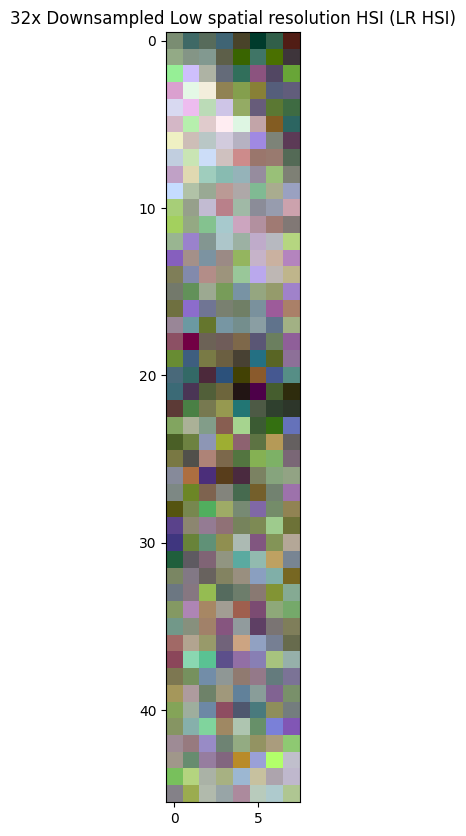

In [17]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_par = spatial_degradation(botswana_image, par_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_par.shape)
visualize_hsi(I_HS_4_par, (20, 9, 5), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_par = spatial_degradation(botswana_image, par_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_par.shape)
visualize_hsi(I_HS_8_par, (20, 9, 5), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_par = spatial_degradation(botswana_image, par_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_par.shape)
visualize_hsi(I_HS_16_par, (20, 9, 5), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_par = spatial_degradation(botswana_image, par_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_par.shape)
visualize_hsi(I_HS_32_par, (20, 9, 5), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Gabor PSF

HSI shape with 4x Downsample:  (369, 64, 145)


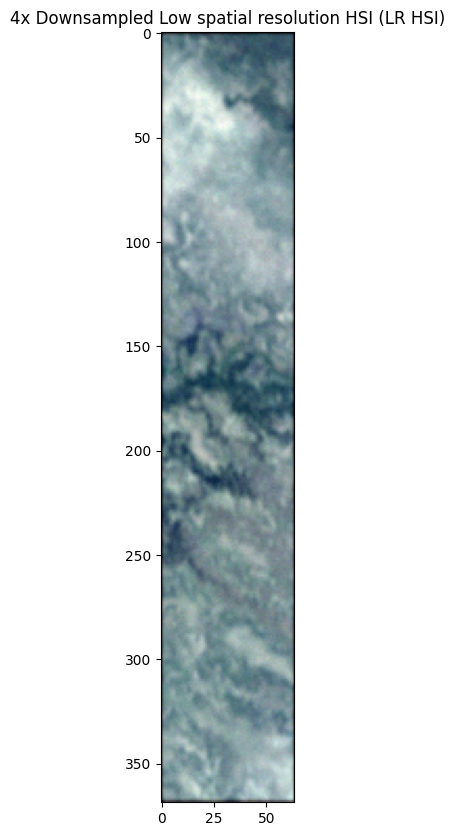

HSI shape with 8x Downsample:  (184, 32, 145)


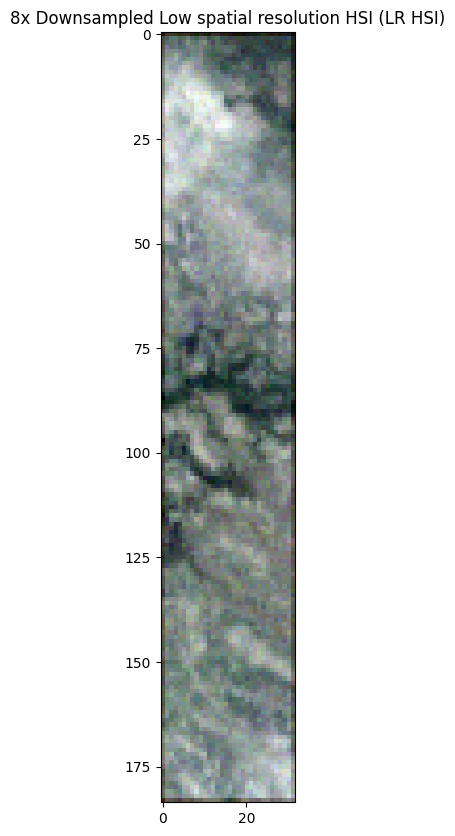

HSI shape with 16x Downsample:  (92, 16, 145)


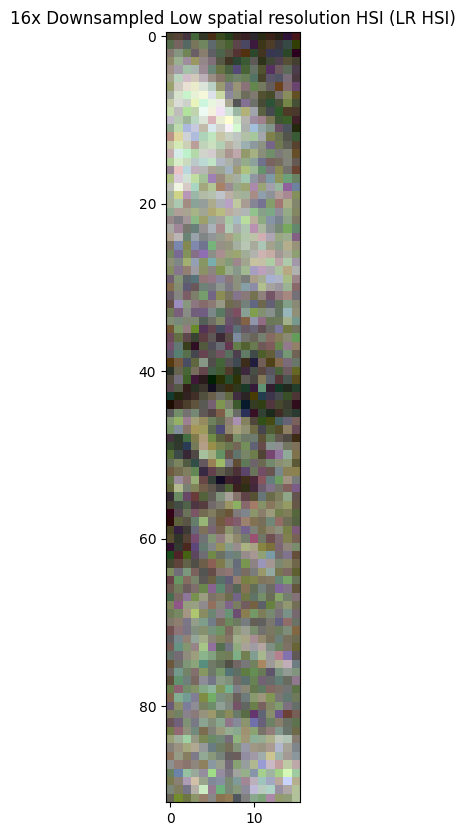

HSI shape with 32x Downsample:  (46, 8, 145)


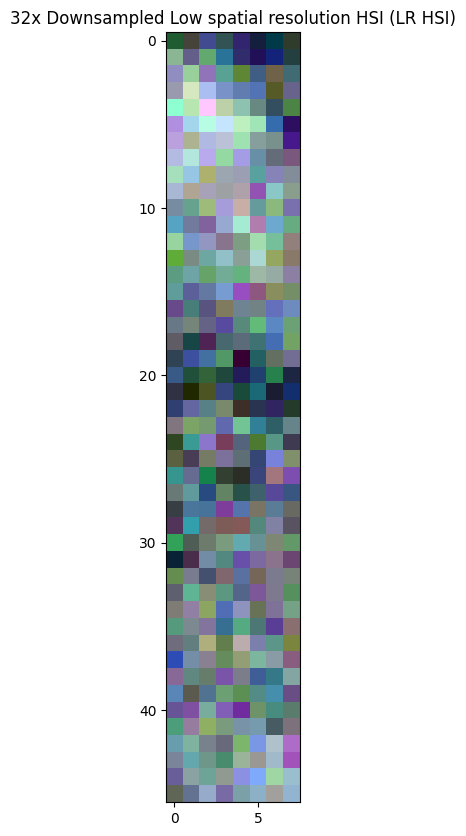

In [18]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gab = spatial_degradation(botswana_image, gab_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_gab.shape)
visualize_hsi(I_HS_4_gab, (20, 9, 5), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gab = spatial_degradation(botswana_image, gab_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_gab.shape)
visualize_hsi(I_HS_8_gab, (20, 9, 5), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gab = spatial_degradation(botswana_image, gab_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_gab.shape)
visualize_hsi(I_HS_16_gab, (20, 9, 5), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gab = spatial_degradation(botswana_image, gab_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_gab.shape)
visualize_hsi(I_HS_32_gab, (20, 9, 5), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Delta PSF

HSI shape with 4x Downsample:  (369, 64, 145)


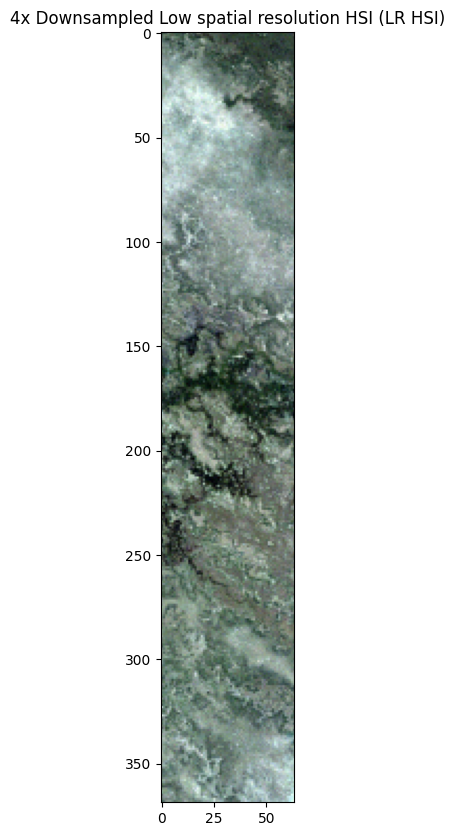

HSI shape with 8x Downsample:  (184, 32, 145)


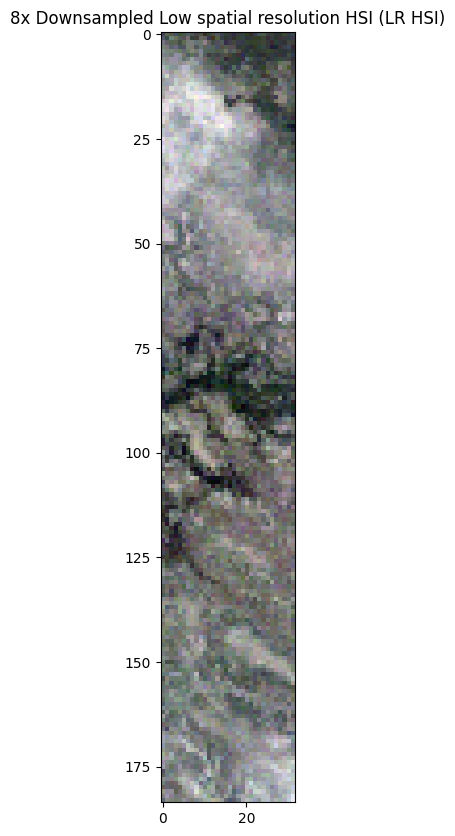

HSI shape with 16x Downsample:  (92, 16, 145)


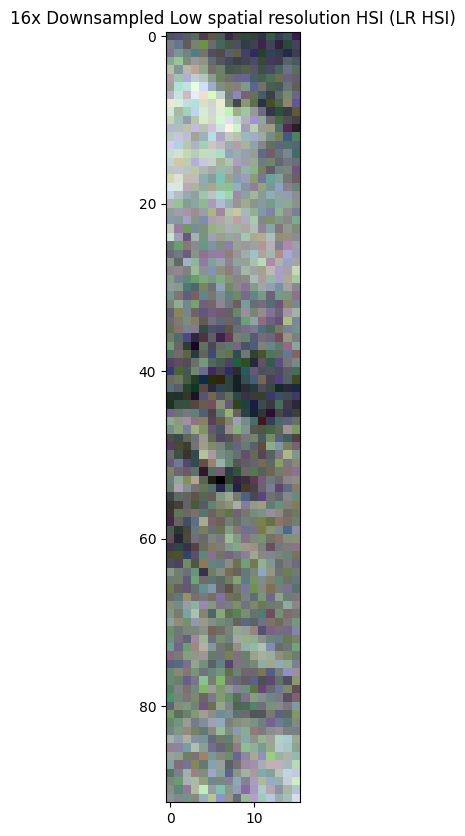

HSI shape with 32x Downsample:  (46, 8, 145)


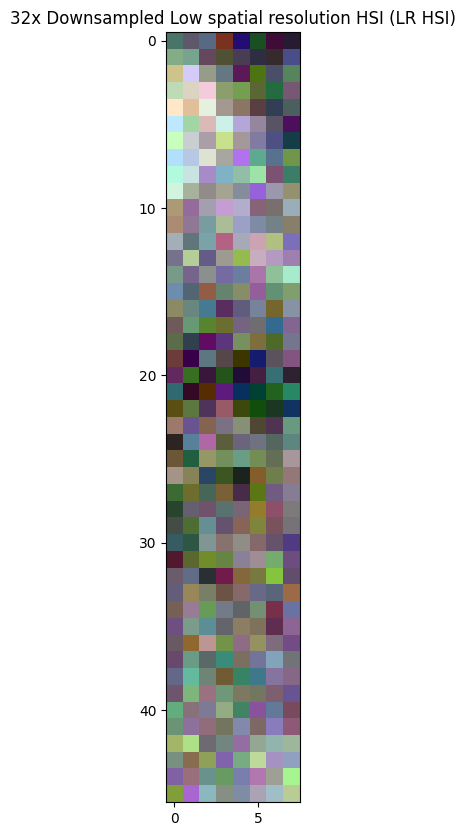

In [19]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_delta = spatial_degradation(botswana_image, delta_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_delta.shape)
visualize_hsi(I_HS_4_delta, (20, 9, 5), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_delta = spatial_degradation(botswana_image, delta_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_delta.shape)
visualize_hsi(I_HS_8_delta, (20, 9, 5), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_delta = spatial_degradation(botswana_image, delta_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_delta.shape)
visualize_hsi(I_HS_16_delta, (20, 9, 5), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_delta = spatial_degradation(botswana_image, delta_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_delta.shape)
visualize_hsi(I_HS_32_delta, (20, 9, 5), "32x Downsampled Low spatial resolution HSI (LR HSI)")

C2FF: Model Guided Coarse to Fine Fusion Network for Unsupervised Hyperspectral Image Super Resolution implementation from their GitHub

In [20]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (pan, lms, ms)).

    Returns
    -------
    flops : str
        FLOPs in readable format.
    param_table : str
        Parameter count in table format.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()
        params = parameter_count_table(model, max_depth=2)
    return flops_total, params

In [21]:
class SimpleConfig:
    def __init__(self):
        # Stage-2 training (C2F) hyperparams
        self.niter2_SPe = 2000
        self.niter_decay2_SPe = 2000
        self.lr_stage2_SPe = 4e-3

        # Basic data specs
        self.scale_factor = 8    # e.g. how much we downsample from HR to LR
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Optional noise settings
        self.noise = "No"
        self.nSNR  = 35

In [22]:
##############################################################################
# Basic building blocks
##############################################################################

class spectral_res_block(nn.Module):
    def __init__(self, input_channel):
        super().__init__()
        self.one=nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=input_channel, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=input_channel, out_channels=input_channel, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
    def forward(self,input):
        identity_data = input
        output = self.one(input)
        return output + identity_data


class refinement(nn.Module):
    def __init__(self, input_channel, output_channel, block_num):
        super().__init__()
        middle = 30
        self.begin = nn.Conv2d(in_channels=input_channel, out_channels=middle, kernel_size=1, stride=1)
        layers = []
        for _ in range(block_num):
            layers.append(spectral_res_block(middle))
        self.middle = nn.Sequential(*layers)
        self.end = nn.Conv2d(in_channels=middle, out_channels=output_channel, kernel_size=1, stride=1)

    def forward(self,input):
        output1 = self.begin(input)
        output2 = self.middle(output1)
        output3 = self.end(output2)
        return output3


class MSAF(nn.Module):
    """
    Multi-Scale Attention Fusion for fusing two LR MSI estimates.
    """
    def __init__(self, input_channel):
        super().__init__()
        self.three=nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size=(1,3), stride=1, padding=(0,1)),
            nn.Conv2d(input_channel, input_channel, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.ReLU(inplace=True)
        )
        self.five=nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size=(1,5), stride=1, padding=(0,2)),
            nn.Conv2d(input_channel, input_channel, kernel_size=(5,1), stride=1, padding=(2,0)),
            nn.ReLU(inplace=True)
        )
        self.seven=nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size=(1,7), stride=1, padding=(0,3)),
            nn.Conv2d(input_channel, input_channel, kernel_size=(7,1), stride=1, padding=(3,0)),
            nn.ReLU(inplace=True)
        )
        self.point_wise1=nn.Sequential(
            nn.Conv2d(input_channel*2, input_channel, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.point_wise2=nn.Sequential(
            nn.Conv2d(input_channel*2, input_channel, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.point_wise3=nn.Sequential(
            nn.Conv2d(input_channel*2, input_channel, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.point_wise4=nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, lr_msi_fhsi, lr_msi_fmsi):
        """
        lr_msi_fhsi, lr_msi_fmsi: shape (1, MS_bands, H_lr, W_lr)
        """
        input_ = lr_msi_fhsi + lr_msi_fmsi
        scale3 = self.three(input_)
        scale5 = self.five(input_)
        scale7 = self.seven(input_)
        pair_35 = torch.cat([scale3, scale5], dim=1)
        pair_57 = torch.cat([scale5, scale7], dim=1)
        pair_37 = torch.cat([scale3, scale7], dim=1)

        out_wise1 = self.point_wise1(pair_35)
        out_wise2 = self.point_wise2(pair_37)
        out_wise3 = self.point_wise3(pair_57)

        spectral_1 = nn.AdaptiveAvgPool2d(1)(out_wise1) + nn.AdaptiveMaxPool2d(1)(out_wise1)
        spectral_2 = nn.AdaptiveAvgPool2d(1)(out_wise2) + nn.AdaptiveMaxPool2d(1)(out_wise2)
        spectral_3 = nn.AdaptiveAvgPool2d(1)(out_wise3) + nn.AdaptiveMaxPool2d(1)(out_wise3)

        spectral_sum = spectral_1 + spectral_2 + spectral_3
        W = self.point_wise4(spectral_sum)

        fused_lr_msi = W * lr_msi_fhsi + (1.0 - W) * lr_msi_fmsi
        return fused_lr_msi, W


class SDG(nn.Module):
    """
    A small sub-network that projects from 1 MSI band to multiple HS bands.
    """
    def __init__(self, input_channel, output_channel):
        super().__init__()
        middle = 5
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=middle, kernel_size=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=middle, out_channels=output_channel, kernel_size=1, stride=1)
        )
    def forward(self, x):
        return self.conv(x)


In [23]:
class SpectralSRWrapper(nn.Module):
    def __init__(self, subnets, refinement):
        super().__init__()
        self.subnets = nn.ModuleList(subnets)
        self.refinement = refinement

    def forward(self, hr_msi):
        B, ms_band, H, W = hr_msi.shape
        hs_band = self.subnets[0].conv[-1].out_channels  # infer from final conv
        hr_hsi_est_srf = torch.zeros((B, hs_band, H, W), device=hr_msi.device)
        for i in range(ms_band):
            in_i = hr_msi[:, i:i+1, :, :]  # (B, 1, H, W)
            out_i = self.subnets[i](in_i)  # (B, HS, H, W)
            hr_hsi_est_srf += out_i / float(ms_band)
        return self.refinement(hr_hsi_est_srf)

In [24]:
##############################################################################
# The "C2F" stage
# Fuses the two LR MSIs, trains sub-networks to up-project them,
# refines that to produce a "super-resolved" HSI from the HR MSI,
# but does not rely on ground-truth HSI for a final metric.
##############################################################################

class spectral_SR:
    def __init__(self, args,
                 lr_msi_fhsi, lr_msi_fmsi,  # (1, MS_bands, H_lr, W_lr)
                 lr_hsi, hr_msi,            # (1, HS_bands, H_lr, W_lr), (1, MS_bands, H_hr, W_hr)
                 lr_msi_gt=None):
        """
        We do not require the ground-truth HSI here, so `gt_np` was removed.
        """
        self.args = args
        self.lr_msi_fhsi = lr_msi_fhsi
        self.lr_msi_fmsi = lr_msi_fmsi
        self.lr_hsi = lr_hsi
        self.hr_msi = hr_msi

        self.hs_band = lr_hsi.shape[1]
        self.ms_band = lr_msi_fhsi.shape[1]

        # Networks
        self.msaf = MSAF(self.ms_band).to(self.args.device)
        self.refinement = refinement(self.hs_band, self.hs_band, block_num=1).to(self.args.device)

        # We'll create a sub-network for each MSI band that projects 1 channel => self.hs_band
        self.subnets = []
        self.optimizers = []
        self.schedulers = []

        # MSAF optimizer
        opt_fusion = optim.Adam(self.msaf.parameters(), lr=self.args.lr_stage2_SPe)
        def lambda_rule2(epoch):
            total = self.args.niter2_SPe + self.args.niter_decay2_SPe
            lr_l = 1.0 - max(0, epoch+1 - self.args.niter2_SPe)/float(self.args.niter_decay2_SPe+1)
            return lr_l
        sch_fusion = lr_scheduler.LambdaLR(opt_fusion, lr_lambda=lambda_rule2)
        self.optimizers.append(opt_fusion)
        self.schedulers.append(sch_fusion)

        # subnets
        for _ in range(self.ms_band):
            net_i = SDG(1, self.hs_band).to(self.args.device)
            opt_i = optim.Adam(net_i.parameters(), lr=self.args.lr_stage2_SPe)
            sch_i = lr_scheduler.LambdaLR(opt_i, lr_lambda=lambda_rule2)
            self.subnets.append(net_i)
            self.optimizers.append(opt_i)
            self.schedulers.append(sch_i)

        # refinement
        opt_refine = optim.Adam(self.refinement.parameters(), lr=self.args.lr_stage2_SPe)
        sch_refine = lr_scheduler.LambdaLR(opt_refine, lr_lambda=lambda_rule2)
        self.optimizers.append(opt_refine)
        self.schedulers.append(sch_refine)

        self.L1Loss = nn.L1Loss().to(self.args.device)

    def train(self):
        """
        Stage-2 trains so that the fused LR HSI approximates the real LR HSI.
        """
        num_epochs = self.args.niter2_SPe + self.args.niter_decay2_SPe
        t_start = time.perf_counter()

        # Use tqdm for the epoch loop
        pbar = tqdm(range(1, num_epochs + 1), desc="C2F Training", dynamic_ncols=True)
        for epoch in pbar:
            # Zero gradients
            for opt in self.optimizers:
                opt.zero_grad()

            # 1) Fuse the two LR MSIs
            fused_lr_msi, _ = self.msaf(self.lr_msi_fhsi, self.lr_msi_fmsi)

            # 2) Build an LR HSI estimate by processing each MSI band via its subnet
            lr_hsi_est_srf = torch.zeros_like(self.lr_hsi)
            for i in range(self.ms_band):
                in_i = fused_lr_msi[:, i:i+1, :, :]  # (1, 1, H_lr, W_lr)
                out_i = self.subnets[i](in_i)          # (1, HS_bands, H_lr, W_lr)
                lr_hsi_est_srf += out_i / float(self.ms_band)

            # 3) Refine
            lr_hsi_est = self.refinement(lr_hsi_est_srf)

            # 4) Compute L1 loss w.r.t. real LR HSI
            loss_lr = self.L1Loss(lr_hsi_est, self.lr_hsi)
            loss_lr.backward()

            # Optimizer step
            for opt in self.optimizers:
                opt.step()
            for sch in self.schedulers:
                sch.step()

            # Update progress bar with current loss
            pbar.set_postfix({'loss': f"{loss_lr.item():.4f}"})
        pbar.close()
        train_time = time.perf_counter() - t_start
        print(f"Train_all done in {train_time:.2f}s")
    
    def get_super_resolved(self):
        """
        Obtain the final super-resolved HSI as a NumPy array.
        Also compute and print model metrics: number of parameters, FLOPs, GPU memory consumed, and inference time.
        """
        self.msaf.eval()
        self.refinement.eval()
        for net in self.subnets:
            net.eval()
        device = self.args.device

        # -------- FLOPs & Param Count (full model) --------
        wrapper_model = SpectralSRWrapper(self.subnets, self.refinement).to(device)
        inputs = (self.hr_msi.to(device), )
        flops_total, _ = get_flops_fvcore(wrapper_model, inputs)
        param_counts = parameter_count(wrapper_model)
        total_params = sum(param_counts.values())

        # Measure GPU memory and inference time
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)
        start_memory = torch.cuda.max_memory_allocated(device)

        with torch.no_grad():
            start_time = time.time()
            hr_hsi_est = wrapper_model(self.hr_msi.to(device))
            end_time = time.time()
        
        end_memory = torch.cuda.max_memory_allocated(device)
        inference_time = end_time - start_time
        gpu_memory_used = end_memory - start_memory

        # Convert output: (1, HS_bands, H_hr, W_hr) -> (H_hr, W_hr, HS_bands)
        X_np = hr_hsi_est[0].cpu().numpy().transpose(1, 2, 0)

        # Print metrics
        print(f"Number of parameters: {total_params}")
        print(f"FLOPs: {flops_total}")
        print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")
        print(f"Inference time: {inference_time:.4f} seconds")
        
        return X_np

In [25]:
def run_pipeline(args, I_LR_HSI, I_HR_MSI, psf, band_specs, downsample_factor):
    """
    Runs the entire pipeline.
    Inputs:
      - I_LR_HSI: shape (H_lr, W_lr, HS_bands)  (NumPy)
      - I_HR_MSI: shape (H_hr, W_hr, MS_bands)  (NumPy)
      - psf: shape: shape (kernel_size, kernel_size) (NumPy)
      - band_specs: shape (num_bands, 3) (NumPy)
      - downsample_factor: int
    Returns:
      - best_sr: The super-resolved HSI of shape (1, HS_bands, H_hr, W_hr)
    """

    device = args.device
    
    # 1) Produce lr_msi images
    lr_msi_fhsi_est, srf, _ = apply_srf(I_LR_HSI, band_specs, fwhm_factor=4.3)
    lr_msi_fmsi_est = apply_psf(I_HR_MSI, psf)
    lr_msi_fmsi_est = downsample_image(lr_msi_fmsi_est, downsample_factor)

    # 2) Convert to Torch Tensors
    lr_hsi_t = torch.from_numpy(I_LR_HSI.transpose(2,0,1)).unsqueeze(0).float().to(device)
    hr_msi_t = torch.from_numpy(I_HR_MSI.transpose(2,0,1)).unsqueeze(0).float().to(device)
    lr_msi_fhsi_est_t = torch.from_numpy(lr_msi_fhsi_est.transpose(2,0,1)).unsqueeze(0).float().to(device)
    lr_msi_fmsi_est_t = torch.from_numpy(lr_msi_fmsi_est.transpose(2,0,1)).unsqueeze(0).float().to(device)
    
    # 3) Stage-2: C2F
    #    We pass the newly learned LR MSI versions, LR HSI, HR MSI, and the SRF
    C2F = spectral_SR(
        args,
        lr_msi_fhsi_est_t, 
        lr_msi_fmsi_est_t,
        lr_hsi_t, 
        hr_msi_t
    )
    
    # Train
    C2F.train()
    
    # Perform inference
    SR_image = C2F.get_super_resolved()

    return SR_image

Output file to save super-resolved images

In [26]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/C2FF"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the C2FF folder
botswana_c2ff_folder_path = os.path.join(normalized_target_path, 'Botswana')

# Create the C2FF folder if it doesn't exist
if not os.path.exists(botswana_c2ff_folder_path):
    os.makedirs(botswana_c2ff_folder_path)

In [27]:
def split_image(image, split_index):
    return image[:split_index], image[split_index:]

def extract_part_to_save(image):
    image = image[:1472, :, :]
    _, image = split_image(image, 1152)
    return image

## Super Resolving HSI degraded with Gaussian PSF

In [28]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
botswana_c2ff_gaus_folder_path = os.path.join(botswana_c2ff_folder_path, 'Gaussian_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(botswana_c2ff_gaus_folder_path):
    os.makedirs(botswana_c2ff_gaus_folder_path)

Running C2FF on Botswana LR HSI with 4x Downsampling and 4 band MSI

In [29]:
args = SimpleConfig()
args.scale_factor = 4   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_4_gaus, I_MS_4, gaus_psf, band_specs_4, 4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gaus_folder_path}/SR_Botswana_gaussian_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_gaus_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:12<00:00, 138.56it/s, loss=0.0058]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 72.18s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0035 seconds
Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_gaus_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 4 band MSI

In [30]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_gaus, I_MS_4, gaus_psf, band_specs_4, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gaus_folder_path}/SR_Botswana_gaussian_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_gaus_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.71it/s, loss=0.0093]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.84s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0055 seconds
Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_gaus_folder_path


Running C2FF on Botswana LR HSI with 16x Downsampling and 4 band MSI

In [31]:
args = SimpleConfig()
args.scale_factor = 16   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_16_gaus, I_MS_4, gaus_psf, band_specs_4, 16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gaus_folder_path}/SR_Botswana_gaussian_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_gaus_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 162.30it/s, loss=0.0156]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.62s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0043 seconds
Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_gaus_folder_path


Running C2FF on Botswana LR HSI with 32x Downsampling and 4 band MSI

In [32]:
args = SimpleConfig()
args.scale_factor = 32   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_32_gaus, I_MS_4, gaus_psf, band_specs_4, 32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gaus_folder_path}/SR_Botswana_gaussian_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_gaus_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 162.32it/s, loss=0.0264]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.61s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0036 seconds
Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_gaus_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 1 band Pan image

In [33]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_gaus, I_MS_1, gaus_psf, band_specs_1, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gaus_folder_path}/SR_Botswana_gaussian_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_gaus_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:44<00:00, 223.82it/s, loss=0.0133]
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 44.68s
Number of parameters: 53800
FLOPs: 4243322880
GPU memory consumed: 716.48 MB
Inference time: 0.0035 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_gaus_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 3 band RGB image

In [34]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_gaus, I_MS_3, gaus_psf, band_specs_3, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gaus_folder_path}/SR_Botswana_gaussian_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_gaus_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:57<00:00, 173.52it/s, loss=0.0096]
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 57.63s
Number of parameters: 64360
FLOPs: 4794992640
GPU memory consumed: 716.48 MB
Inference time: 0.0045 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_gaus_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 8 band MSI

In [35]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_gaus, I_MS_8, gaus_psf, band_specs_8, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gaus_folder_path}/SR_Botswana_gaussian_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_gaus_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:21<00:00, 122.78it/s, loss=0.0088]
Unsupported operator aten::div encountered 8 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 81.45s
Number of parameters: 90760
FLOPs: 6174167040
GPU memory consumed: 716.48 MB
Inference time: 0.0031 seconds
Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_gaus_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 16 band MSI

In [36]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_gaus, I_MS_16, gaus_psf, band_specs_16, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gaus_folder_path}/SR_Botswana_gaussian_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_gaus_folder_path")

C2F Training: 100%|██████████| 10000/10000 [02:39<00:00, 62.75it/s, loss=0.0088]
Unsupported operator aten::div encountered 16 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 159.36s
Number of parameters: 133000
FLOPs: 8380846080
GPU memory consumed: 716.48 MB
Inference time: 0.0046 seconds
Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_gaus_folder_path


## Super Resolving HSI degraded with Kolmogorov PSF

In [37]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
botswana_c2ff_kol_folder_path = os.path.join(botswana_c2ff_folder_path, 'Kolmogorov_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(botswana_c2ff_kol_folder_path):
    os.makedirs(botswana_c2ff_kol_folder_path)

Running C2FF on Botswana LR HSI with 4x Downsampling and 4 band MSI

In [38]:
args = SimpleConfig()
args.scale_factor = 4   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_4_kol, I_MS_4, kol_psf, band_specs_4, 4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_kol_folder_path}/SR_Botswana_kolmogorov_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_kol_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:12<00:00, 138.58it/s, loss=0.0059]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 72.16s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0028 seconds
Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_kol_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 4 band MSI

In [39]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_kol, I_MS_4, kol_psf, band_specs_4, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_kol_folder_path}/SR_Botswana_kolmogorov_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_kol_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.99it/s, loss=0.0093]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.73s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0029 seconds
Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_kol_folder_path


Running C2FF on Botswana LR HSI with 16x Downsampling and 4 band MSI

In [40]:
args = SimpleConfig()
args.scale_factor = 16   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_16_kol, I_MS_4, kol_psf, band_specs_4, 16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_kol_folder_path}/SR_Botswana_kolmogorov_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_kol_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:02<00:00, 161.22it/s, loss=0.0156]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 62.03s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0028 seconds
Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_kol_folder_path


Running C2FF on Botswana LR HSI with 32x Downsampling and 4 band MSI

In [41]:
args = SimpleConfig()
args.scale_factor = 32   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_32_kol, I_MS_4, kol_psf, band_specs_4, 32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_kol_folder_path}/SR_Botswana_kolmogorov_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_kol_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.84it/s, loss=0.0263]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.79s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0032 seconds
Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_kol_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 1 band Pan image

In [42]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_kol, I_MS_1, kol_psf, band_specs_1, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_kol_folder_path}/SR_Botswana_kolmogorov_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_kol_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:44<00:00, 223.90it/s, loss=0.0133]
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 44.66s
Number of parameters: 53800
FLOPs: 4243322880
GPU memory consumed: 716.48 MB
Inference time: 0.0028 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_kol_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 3 band RGB image

In [43]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_kol, I_MS_3, kol_psf, band_specs_3, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_kol_folder_path}/SR_Botswana_kolmogorov_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_kol_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:57<00:00, 173.15it/s, loss=0.0096]
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 57.76s
Number of parameters: 64360
FLOPs: 4794992640
GPU memory consumed: 716.48 MB
Inference time: 0.0028 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_kol_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 8 band MSI

In [44]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_kol, I_MS_8, kol_psf, band_specs_8, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_kol_folder_path}/SR_Botswana_kolmogorov_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_kol_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:21<00:00, 122.60it/s, loss=0.0089]
Unsupported operator aten::div encountered 8 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 81.57s
Number of parameters: 90760
FLOPs: 6174167040
GPU memory consumed: 716.48 MB
Inference time: 0.0031 seconds
Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_kol_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 16 band MSI

In [45]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_kol, I_MS_16, kol_psf, band_specs_16, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_kol_folder_path}/SR_Botswana_kolmogorov_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_kol_folder_path")

C2F Training: 100%|██████████| 10000/10000 [02:25<00:00, 68.55it/s, loss=0.0088]
Unsupported operator aten::div encountered 16 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 145.87s
Number of parameters: 133000
FLOPs: 8380846080
GPU memory consumed: 716.48 MB
Inference time: 0.0045 seconds
Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_kol_folder_path


## Super Resolving HSI degraded with Airy PSF

In [46]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
botswana_c2ff_air_folder_path = os.path.join(botswana_c2ff_folder_path, 'Airy_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(botswana_c2ff_air_folder_path):
    os.makedirs(botswana_c2ff_air_folder_path)

Running C2FF on Botswana LR HSI with 4x Downsampling and 4 band MSI

In [47]:
args = SimpleConfig()
args.scale_factor = 4   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_4_air, I_MS_4, air_psf, band_specs_4, 4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_air_folder_path}/SR_Botswana_airy_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_air_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:11<00:00, 139.28it/s, loss=0.0062]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 71.80s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0029 seconds
Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_air_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 4 band MSI

In [48]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_air, I_MS_4, air_psf, band_specs_4, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_air_folder_path}/SR_Botswana_airy_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_air_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.57it/s, loss=0.0094]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.90s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0030 seconds
Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_air_folder_path


Running C2FF on Botswana LR HSI with 16x Downsampling and 4 band MSI

In [49]:
args = SimpleConfig()
args.scale_factor = 16   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_16_air, I_MS_4, air_psf, band_specs_4, 16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_air_folder_path}/SR_Botswana_airy_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_air_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.92it/s, loss=0.0157]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.76s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0030 seconds
Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_air_folder_path


Running C2FF on Botswana LR HSI with 32x Downsampling and 4 band MSI

In [50]:
args = SimpleConfig()
args.scale_factor = 32   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_32_air, I_MS_4, air_psf, band_specs_4, 32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_air_folder_path}/SR_Botswana_airy_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_air_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 162.85it/s, loss=0.0272]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.41s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0031 seconds
Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_air_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 1 band Pan image

In [51]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_air, I_MS_1, air_psf, band_specs_1, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_air_folder_path}/SR_Botswana_airy_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_air_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:44<00:00, 224.11it/s, loss=0.0137]
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 44.62s
Number of parameters: 53800
FLOPs: 4243322880
GPU memory consumed: 716.48 MB
Inference time: 0.0028 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_air_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 3 band RGB image

In [52]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_air, I_MS_3, air_psf, band_specs_3, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_air_folder_path}/SR_Botswana_airy_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_air_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:58<00:00, 172.30it/s, loss=0.0096]
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 58.04s
Number of parameters: 64360
FLOPs: 4794992640
GPU memory consumed: 716.48 MB
Inference time: 0.0030 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_air_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 8 band MSI

In [53]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_air, I_MS_8, air_psf, band_specs_8, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_air_folder_path}/SR_Botswana_airy_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_air_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:22<00:00, 121.86it/s, loss=0.0090]
Unsupported operator aten::div encountered 8 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 82.07s
Number of parameters: 90760
FLOPs: 6174167040
GPU memory consumed: 716.48 MB
Inference time: 0.0032 seconds
Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_air_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 16 band MSI

In [54]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_air, I_MS_16, air_psf, band_specs_16, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_air_folder_path}/SR_Botswana_airy_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_air_folder_path")

C2F Training: 100%|██████████| 10000/10000 [02:29<00:00, 66.95it/s, loss=0.0090]
Unsupported operator aten::div encountered 16 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 149.38s
Number of parameters: 133000
FLOPs: 8380846080
GPU memory consumed: 716.48 MB
Inference time: 0.0048 seconds
Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_air_folder_path


## Super Resolving HSI degraded with Moffat PSF

In [55]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
botswana_c2ff_mof_folder_path = os.path.join(botswana_c2ff_folder_path, 'Moffat_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(botswana_c2ff_mof_folder_path):
    os.makedirs(botswana_c2ff_mof_folder_path)

Running C2FF on Botswana LR HSI with 4x Downsampling and 4 band MSI

In [56]:
args = SimpleConfig()
args.scale_factor = 4   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_4_mof, I_MS_4, mof_psf, band_specs_4, 4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_mof_folder_path}/SR_Botswana_moffat_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_mof_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:11<00:00, 139.05it/s, loss=0.0071]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 71.92s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0028 seconds
Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_mof_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 4 band MSI

In [57]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_mof, I_MS_4, mof_psf, band_specs_4, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_mof_folder_path}/SR_Botswana_moffat_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_mof_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.57it/s, loss=0.0094]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.90s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0030 seconds
Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_mof_folder_path


Running C2FF on Botswana LR HSI with 16x Downsampling and 4 band MSI

In [58]:
args = SimpleConfig()
args.scale_factor = 16   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_16_mof, I_MS_4, mof_psf, band_specs_4, 16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_mof_folder_path}/SR_Botswana_moffat_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_mof_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.83it/s, loss=0.0156]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.80s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0029 seconds
Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_mof_folder_path


Running C2FF on Botswana LR HSI with 32x Downsampling and 4 band MSI

In [59]:
args = SimpleConfig()
args.scale_factor = 32   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_32_mof, I_MS_4, mof_psf, band_specs_4, 32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_mof_folder_path}/SR_Botswana_moffat_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_mof_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 163.18it/s, loss=0.0265]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.29s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0032 seconds
Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_mof_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 1 band Pan image

In [60]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_mof, I_MS_1, mof_psf, band_specs_1, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_mof_folder_path}/SR_Botswana_moffat_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_mof_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:44<00:00, 223.53it/s, loss=0.0135]
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 44.74s
Number of parameters: 53800
FLOPs: 4243322880
GPU memory consumed: 716.48 MB
Inference time: 0.0028 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_mof_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 3 band RGB image

In [61]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_mof, I_MS_3, mof_psf, band_specs_3, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_mof_folder_path}/SR_Botswana_moffat_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_mof_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:57<00:00, 172.50it/s, loss=0.0124]
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 57.97s
Number of parameters: 64360
FLOPs: 4794992640
GPU memory consumed: 716.48 MB
Inference time: 0.0030 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_mof_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 8 band MSI

In [62]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_mof, I_MS_8, mof_psf, band_specs_8, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_mof_folder_path}/SR_Botswana_moffat_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_mof_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:21<00:00, 123.12it/s, loss=0.0089]
Unsupported operator aten::div encountered 8 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 81.23s
Number of parameters: 90760
FLOPs: 6174167040
GPU memory consumed: 716.48 MB
Inference time: 0.0033 seconds
Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_mof_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 16 band MSI

In [63]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_mof, I_MS_16, mof_psf, band_specs_16, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_mof_folder_path}/SR_Botswana_moffat_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_mof_folder_path")

C2F Training: 100%|██████████| 10000/10000 [02:29<00:00, 66.83it/s, loss=0.0087]
Unsupported operator aten::div encountered 16 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 149.64s
Number of parameters: 133000
FLOPs: 8380846080
GPU memory consumed: 716.48 MB
Inference time: 0.0054 seconds
Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_mof_folder_path


## Super Resolving HSI degraded with Sinc PSF

In [64]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
botswana_c2ff_sinc_folder_path = os.path.join(botswana_c2ff_folder_path, 'Sinc_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(botswana_c2ff_sinc_folder_path):
    os.makedirs(botswana_c2ff_sinc_folder_path)

Running C2FF on Botswana LR HSI with 4x Downsampling and 4 band MSI

In [65]:
args = SimpleConfig()
args.scale_factor = 4   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_4_sinc, I_MS_4, sinc_psf, band_specs_4, 4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_sinc_folder_path}/SR_Botswana_sinc_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_sinc_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:11<00:00, 139.13it/s, loss=0.0068]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 71.88s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0045 seconds
Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_sinc_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 4 band MSI

In [66]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_sinc, I_MS_4, sinc_psf, band_specs_4, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_sinc_folder_path}/SR_Botswana_sinc_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_sinc_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:02<00:00, 161.28it/s, loss=0.0101]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 62.01s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0036 seconds
Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_sinc_folder_path


Running C2FF on Botswana LR HSI with 16x Downsampling and 4 band MSI

In [67]:
args = SimpleConfig()
args.scale_factor = 16   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_16_sinc, I_MS_4, sinc_psf, band_specs_4, 16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_sinc_folder_path}/SR_Botswana_sinc_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_sinc_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 162.42it/s, loss=0.0157]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.57s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0036 seconds
Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_sinc_folder_path


Running C2FF on Botswana LR HSI with 32x Downsampling and 4 band MSI

In [68]:
args = SimpleConfig()
args.scale_factor = 32   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_32_sinc, I_MS_4, sinc_psf, band_specs_4, 32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_sinc_folder_path}/SR_Botswana_sinc_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_sinc_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 163.01it/s, loss=0.0269]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.35s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0035 seconds
Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_sinc_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 1 band Pan image

In [69]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_sinc, I_MS_1, sinc_psf, band_specs_1, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_sinc_folder_path}/SR_Botswana_sinc_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_sinc_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:44<00:00, 224.40it/s, loss=0.0141]
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 44.57s
Number of parameters: 53800
FLOPs: 4243322880
GPU memory consumed: 716.48 MB
Inference time: 0.0036 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_sinc_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 3 band RGB image

In [70]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_sinc, I_MS_3, sinc_psf, band_specs_3, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_sinc_folder_path}/SR_Botswana_sinc_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_sinc_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:57<00:00, 172.81it/s, loss=0.0097]
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 57.87s
Number of parameters: 64360
FLOPs: 4794992640
GPU memory consumed: 716.48 MB
Inference time: 0.0035 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_sinc_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 8 band MSI

In [71]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_sinc, I_MS_8, sinc_psf, band_specs_8, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_sinc_folder_path}/SR_Botswana_sinc_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_sinc_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:21<00:00, 122.39it/s, loss=0.0092]
Unsupported operator aten::div encountered 8 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 81.71s
Number of parameters: 90760
FLOPs: 6174167040
GPU memory consumed: 716.48 MB
Inference time: 0.0034 seconds
Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_sinc_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 16 band MSI

In [72]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_sinc, I_MS_16, sinc_psf, band_specs_16, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_sinc_folder_path}/SR_Botswana_sinc_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_sinc_folder_path")

C2F Training: 100%|██████████| 10000/10000 [02:42<00:00, 61.39it/s, loss=0.0088]
Unsupported operator aten::div encountered 16 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 162.90s
Number of parameters: 133000
FLOPs: 8380846080
GPU memory consumed: 716.48 MB
Inference time: 0.0053 seconds
Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_sinc_folder_path


## Super Resolving HSI degraded with Lorentzian Squared PSF

In [73]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
botswana_c2ff_lor_sq_folder_path = os.path.join(botswana_c2ff_folder_path, 'Lorentzian_Squared_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(botswana_c2ff_lor_sq_folder_path):
    os.makedirs(botswana_c2ff_lor_sq_folder_path)

Running C2FF on Botswana LR HSI with 4x Downsampling and 4 band MSI

In [74]:
args = SimpleConfig()
args.scale_factor = 4   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_4_lor_sq, I_MS_4, lor_sq_psf, band_specs_4, 4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_lor_sq_folder_path}/SR_Botswana_lorentzian_squared_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_lor_sq_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:12<00:00, 138.80it/s, loss=0.0059]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 72.05s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0107 seconds
Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_lor_sq_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 4 band MSI

In [75]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_lor_sq, I_MS_4, lor_sq_psf, band_specs_4, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_lor_sq_folder_path}/SR_Botswana_lorentzian_squared_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_lor_sq_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.93it/s, loss=0.0094]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.76s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0035 seconds
Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_lor_sq_folder_path


Running C2FF on Botswana LR HSI with 16x Downsampling and 4 band MSI

In [76]:
args = SimpleConfig()
args.scale_factor = 16   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_16_lor_sq, I_MS_4, lor_sq_psf, band_specs_4, 16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_lor_sq_folder_path}/SR_Botswana_lorentzian_squared_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_lor_sq_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.77it/s, loss=0.0156]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.82s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0045 seconds
Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_lor_sq_folder_path


Running C2FF on Botswana LR HSI with 32x Downsampling and 4 band MSI

In [77]:
args = SimpleConfig()
args.scale_factor = 32   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_32_lor_sq, I_MS_4, lor_sq_psf, band_specs_4, 32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_lor_sq_folder_path}/SR_Botswana_lorentzian_squared_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_lor_sq_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 163.06it/s, loss=0.0263]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.33s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0037 seconds
Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_lor_sq_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 1 band Pan image

In [78]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_lor_sq, I_MS_1, lor_sq_psf, band_specs_1, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_lor_sq_folder_path}/SR_Botswana_lorentzian_squared_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_lor_sq_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:44<00:00, 224.38it/s, loss=0.0133]
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 44.57s
Number of parameters: 53800
FLOPs: 4243322880
GPU memory consumed: 716.48 MB
Inference time: 0.0035 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_lor_sq_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 3 band RGB image

In [79]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_lor_sq, I_MS_3, lor_sq_psf, band_specs_3, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_lor_sq_folder_path}/SR_Botswana_lorentzian_squared_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_lor_sq_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:57<00:00, 173.19it/s, loss=0.0096]
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 57.74s
Number of parameters: 64360
FLOPs: 4794992640
GPU memory consumed: 716.48 MB
Inference time: 0.0036 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_lor_sq_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 8 band MSI

In [80]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_lor_sq, I_MS_8, lor_sq_psf, band_specs_8, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_lor_sq_folder_path}/SR_Botswana_lorentzian_squared_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_lor_sq_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:21<00:00, 122.27it/s, loss=0.0089]
Unsupported operator aten::div encountered 8 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 81.79s
Number of parameters: 90760
FLOPs: 6174167040
GPU memory consumed: 716.48 MB
Inference time: 0.0035 seconds
Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_lor_sq_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 16 band MSI

In [81]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_lor_sq, I_MS_16, lor_sq_psf, band_specs_16, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_lor_sq_folder_path}/SR_Botswana_lorentzian_squared_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_lor_sq_folder_path")

C2F Training: 100%|██████████| 10000/10000 [02:46<00:00, 59.98it/s, loss=0.0087]
Unsupported operator aten::div encountered 16 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 166.73s
Number of parameters: 133000
FLOPs: 8380846080
GPU memory consumed: 716.48 MB
Inference time: 0.0054 seconds
Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_lor_sq_folder_path


## Super Resolving HSI degraded with Hermite PSF

In [82]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
botswana_c2ff_her_folder_path = os.path.join(botswana_c2ff_folder_path, 'Hermite_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(botswana_c2ff_her_folder_path):
    os.makedirs(botswana_c2ff_her_folder_path)

Running C2FF on Botswana LR HSI with 4x Downsampling and 4 band MSI

In [83]:
args = SimpleConfig()
args.scale_factor = 4   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_4_her, I_MS_4, her_psf, band_specs_4, 4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_her_folder_path}/SR_Botswana_hermite_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_her_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:12<00:00, 138.83it/s, loss=0.0057]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 72.03s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0044 seconds
Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_her_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 4 band MSI

In [84]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_her, I_MS_4, her_psf, band_specs_4, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_her_folder_path}/SR_Botswana_hermite_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_her_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:02<00:00, 160.87it/s, loss=0.0092]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 62.16s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0034 seconds
Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_her_folder_path


Running C2FF on Botswana LR HSI with 16x Downsampling and 4 band MSI

In [85]:
args = SimpleConfig()
args.scale_factor = 16   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_16_her, I_MS_4, her_psf, band_specs_4, 16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_her_folder_path}/SR_Botswana_hermite_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_her_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:02<00:00, 161.02it/s, loss=0.0155]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 62.10s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0044 seconds
Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_her_folder_path


Running C2FF on Botswana LR HSI with 32x Downsampling and 4 band MSI

In [86]:
args = SimpleConfig()
args.scale_factor = 32   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_32_her, I_MS_4, her_psf, band_specs_4, 32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_her_folder_path}/SR_Botswana_hermite_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_her_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 162.56it/s, loss=0.0266]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.52s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0036 seconds
Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_her_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 1 band Pan image

In [87]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_her, I_MS_1, her_psf, band_specs_1, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_her_folder_path}/SR_Botswana_hermite_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_her_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:44<00:00, 223.64it/s, loss=0.0132]
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 44.72s
Number of parameters: 53800
FLOPs: 4243322880
GPU memory consumed: 716.48 MB
Inference time: 0.0044 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_her_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 3 band RGB image

In [88]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_her, I_MS_3, her_psf, band_specs_3, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_her_folder_path}/SR_Botswana_hermite_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_her_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:58<00:00, 171.75it/s, loss=0.0095]
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 58.23s
Number of parameters: 64360
FLOPs: 4794992640
GPU memory consumed: 716.48 MB
Inference time: 0.0034 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_her_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 8 band MSI

In [89]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_her, I_MS_8, her_psf, band_specs_8, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_her_folder_path}/SR_Botswana_hermite_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_her_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:22<00:00, 121.54it/s, loss=0.0088]
Unsupported operator aten::div encountered 8 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 82.28s
Number of parameters: 90760
FLOPs: 6174167040
GPU memory consumed: 716.48 MB
Inference time: 0.0044 seconds
Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_her_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 16 band MSI

In [90]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_her, I_MS_16, her_psf, band_specs_16, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_her_folder_path}/SR_Botswana_hermite_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_her_folder_path")

C2F Training: 100%|██████████| 10000/10000 [02:43<00:00, 61.24it/s, loss=0.0087]
Unsupported operator aten::div encountered 16 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 163.29s
Number of parameters: 133000
FLOPs: 8380846080
GPU memory consumed: 716.48 MB
Inference time: 0.0046 seconds
Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_her_folder_path


## Super Resolving HSI degraded with Parabolic PSF

In [91]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
botswana_c2ff_par_folder_path = os.path.join(botswana_c2ff_folder_path, 'Parabolic_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(botswana_c2ff_par_folder_path):
    os.makedirs(botswana_c2ff_par_folder_path)

Running C2FF on Botswana LR HSI with 4x Downsampling and 4 band MSI

In [92]:
args = SimpleConfig()
args.scale_factor = 4   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_4_par, I_MS_4, par_psf, band_specs_4, 4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_par_folder_path}/SR_Botswana_parabolic_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_par_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:12<00:00, 138.66it/s, loss=0.0060]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 72.12s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0035 seconds
Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_par_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 4 band MSI

In [93]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_par, I_MS_4, par_psf, band_specs_4, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_par_folder_path}/SR_Botswana_parabolic_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_par_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.32it/s, loss=0.0093]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.99s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0036 seconds
Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_par_folder_path


Running C2FF on Botswana LR HSI with 16x Downsampling and 4 band MSI

In [94]:
args = SimpleConfig()
args.scale_factor = 16   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_16_par, I_MS_4, par_psf, band_specs_4, 16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_par_folder_path}/SR_Botswana_parabolic_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_par_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.47it/s, loss=0.0157]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.94s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0036 seconds
Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_par_folder_path


Running C2FF on Botswana LR HSI with 32x Downsampling and 4 band MSI

In [95]:
args = SimpleConfig()
args.scale_factor = 32   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_32_par, I_MS_4, par_psf, band_specs_4, 32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_par_folder_path}/SR_Botswana_parabolic_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_par_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 162.25it/s, loss=0.0264]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.64s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0047 seconds
Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_par_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 1 band Pan image

In [96]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_par, I_MS_1, par_psf, band_specs_1, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_par_folder_path}/SR_Botswana_parabolic_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_par_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:44<00:00, 222.44it/s, loss=0.0136]
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 44.96s
Number of parameters: 53800
FLOPs: 4243322880
GPU memory consumed: 716.48 MB
Inference time: 0.0044 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_par_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 3 band RGB image

In [97]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_par, I_MS_3, par_psf, band_specs_3, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_par_folder_path}/SR_Botswana_parabolic_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_par_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:58<00:00, 172.22it/s, loss=0.0096]
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 58.07s
Number of parameters: 64360
FLOPs: 4794992640
GPU memory consumed: 716.48 MB
Inference time: 0.0036 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_par_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 8 band MSI

In [98]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_par, I_MS_8, par_psf, band_specs_8, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_par_folder_path}/SR_Botswana_parabolic_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_par_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:21<00:00, 122.03it/s, loss=0.0090]
Unsupported operator aten::div encountered 8 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 81.95s
Number of parameters: 90760
FLOPs: 6174167040
GPU memory consumed: 716.48 MB
Inference time: 0.0034 seconds
Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_par_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 16 band MSI

In [99]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_par, I_MS_16, par_psf, band_specs_16, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_par_folder_path}/SR_Botswana_parabolic_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_par_folder_path")

C2F Training: 100%|██████████| 10000/10000 [02:46<00:00, 60.01it/s, loss=0.0088]
Unsupported operator aten::div encountered 16 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 166.63s
Number of parameters: 133000
FLOPs: 8380846080
GPU memory consumed: 716.48 MB
Inference time: 0.0047 seconds
Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_par_folder_path


## Super Resolving HSI degraded with Gabor PSF

In [100]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
botswana_c2ff_gab_folder_path = os.path.join(botswana_c2ff_folder_path, 'Gabor_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(botswana_c2ff_gab_folder_path):
    os.makedirs(botswana_c2ff_gab_folder_path)

Running C2FF on Botswana LR HSI with 4x Downsampling and 4 band MSI

In [101]:
args = SimpleConfig()
args.scale_factor = 4   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_4_gab, I_MS_4, gab_psf, band_specs_4, 4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gab_folder_path}/SR_Botswana_gabor_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_gab_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:11<00:00, 139.00it/s, loss=0.0058]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 71.94s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0039 seconds
Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_gab_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 4 band MSI

In [102]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_gab, I_MS_4, gab_psf, band_specs_4, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gab_folder_path}/SR_Botswana_gabor_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_gab_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:02<00:00, 161.24it/s, loss=0.0093]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 62.02s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0030 seconds
Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_gab_folder_path


Running C2FF on Botswana LR HSI with 16x Downsampling and 4 band MSI

In [103]:
args = SimpleConfig()
args.scale_factor = 16   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_16_gab, I_MS_4, gab_psf, band_specs_4, 16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gab_folder_path}/SR_Botswana_gabor_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_gab_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 162.17it/s, loss=0.0155]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.67s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0029 seconds
Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_gab_folder_path


Running C2FF on Botswana LR HSI with 32x Downsampling and 4 band MSI

In [104]:
args = SimpleConfig()
args.scale_factor = 32   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_32_gab, I_MS_4, gab_psf, band_specs_4, 32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gab_folder_path}/SR_Botswana_gabor_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_gab_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 162.92it/s, loss=0.0263]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.38s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0031 seconds
Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_gab_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 1 band Pan image

In [105]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_gab, I_MS_1, gab_psf, band_specs_1, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gab_folder_path}/SR_Botswana_gabor_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_gab_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:44<00:00, 223.73it/s, loss=0.0132]
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 44.70s
Number of parameters: 53800
FLOPs: 4243322880
GPU memory consumed: 716.48 MB
Inference time: 0.0028 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_gab_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 3 band RGB image

In [106]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_gab, I_MS_3, gab_psf, band_specs_3, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gab_folder_path}/SR_Botswana_gabor_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_gab_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:57<00:00, 172.66it/s, loss=0.0096]
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 57.92s
Number of parameters: 64360
FLOPs: 4794992640
GPU memory consumed: 716.48 MB
Inference time: 0.0030 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_gab_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 8 band MSI

In [107]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_gab, I_MS_8, gab_psf, band_specs_8, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gab_folder_path}/SR_Botswana_gabor_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_gab_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:21<00:00, 122.34it/s, loss=0.0088]
Unsupported operator aten::div encountered 8 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 81.74s
Number of parameters: 90760
FLOPs: 6174167040
GPU memory consumed: 716.48 MB
Inference time: 0.0032 seconds
Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_gab_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 16 band MSI

In [108]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_gab, I_MS_16, gab_psf, band_specs_16, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_gab_folder_path}/SR_Botswana_gabor_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_gab_folder_path")

C2F Training: 100%|██████████| 10000/10000 [02:31<00:00, 65.87it/s, loss=0.0086]
Unsupported operator aten::div encountered 16 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 151.82s
Number of parameters: 133000
FLOPs: 8380846080
GPU memory consumed: 716.48 MB
Inference time: 0.0038 seconds
Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_gab_folder_path


## Super Resolving HSI degraded with Delta PSF

In [109]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
botswana_c2ff_delta_folder_path = os.path.join(botswana_c2ff_folder_path, 'Delta_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(botswana_c2ff_delta_folder_path):
    os.makedirs(botswana_c2ff_delta_folder_path)

Running C2FF on Botswana LR HSI with 4x Downsampling and 4 band MSI

In [110]:
args = SimpleConfig()
args.scale_factor = 4   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_4_delta, I_MS_4, delta_psf, band_specs_4, 4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_delta_folder_path}/SR_Botswana_delta_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_delta_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:11<00:00, 139.74it/s, loss=0.0065]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 71.56s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0029 seconds
Saved 4x super resolved image from 4 band MSI at location specified in botswana_c2ff_delta_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 4 band MSI

In [111]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_delta, I_MS_4, delta_psf, band_specs_4, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_delta_folder_path}/SR_Botswana_delta_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_delta_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.60it/s, loss=0.0094]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.88s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0030 seconds
Saved 8x super resolved image from 4 band MSI at location specified in botswana_c2ff_delta_folder_path


Running C2FF on Botswana LR HSI with 16x Downsampling and 4 band MSI

In [112]:
args = SimpleConfig()
args.scale_factor = 16   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_16_delta, I_MS_4, delta_psf, band_specs_4, 16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_delta_folder_path}/SR_Botswana_delta_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_delta_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 161.68it/s, loss=0.0158]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.85s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0030 seconds
Saved 16x super resolved image from 4 band MSI at location specified in botswana_c2ff_delta_folder_path


Running C2FF on Botswana LR HSI with 32x Downsampling and 4 band MSI

In [113]:
args = SimpleConfig()
args.scale_factor = 32   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_32_delta, I_MS_4, delta_psf, band_specs_4, 32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_delta_folder_path}/SR_Botswana_delta_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_delta_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:01<00:00, 162.56it/s, loss=0.0262]
Unsupported operator aten::div encountered 4 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 61.52s
Number of parameters: 69640
FLOPs: 5070827520
GPU memory consumed: 716.48 MB
Inference time: 0.0031 seconds
Saved 32x super resolved image from 4 band MSI at location specified in botswana_c2ff_delta_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 1 band Pan image

In [114]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_delta, I_MS_1, delta_psf, band_specs_1, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_delta_folder_path}/SR_Botswana_delta_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_delta_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:44<00:00, 223.76it/s, loss=0.0139]
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 44.69s
Number of parameters: 53800
FLOPs: 4243322880
GPU memory consumed: 716.48 MB
Inference time: 0.0029 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in botswana_c2ff_delta_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 3 band RGB image

In [115]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_delta, I_MS_3, delta_psf, band_specs_3, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_delta_folder_path}/SR_Botswana_delta_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_delta_folder_path")

C2F Training: 100%|██████████| 10000/10000 [00:57<00:00, 172.81it/s, loss=0.0097]
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 57.87s
Number of parameters: 64360
FLOPs: 4794992640
GPU memory consumed: 716.48 MB
Inference time: 0.0029 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in botswana_c2ff_delta_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 8 band MSI

In [116]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_delta, I_MS_8, delta_psf, band_specs_8, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_delta_folder_path}/SR_Botswana_delta_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_delta_folder_path")

C2F Training: 100%|██████████| 10000/10000 [01:22<00:00, 121.75it/s, loss=0.0090]
Unsupported operator aten::div encountered 8 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 82.14s
Number of parameters: 90760
FLOPs: 6174167040
GPU memory consumed: 716.48 MB
Inference time: 0.0032 seconds
Saved 8x super resolved image from 8 band MSI at location specified in botswana_c2ff_delta_folder_path


Running C2FF on Botswana LR HSI with 8x Downsampling and 16 band MSI

In [117]:
args = SimpleConfig()
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image = run_pipeline(args, I_HS_8_delta, I_MS_16, delta_psf, band_specs_16, 8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{botswana_c2ff_delta_folder_path}/SR_Botswana_delta_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_delta_folder_path")

C2F Training: 100%|██████████| 10000/10000 [02:34<00:00, 64.76it/s, loss=0.0089]
Unsupported operator aten::div encountered 16 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::add encountered 1 time(s)


Train_all done in 154.42s
Number of parameters: 133000
FLOPs: 8380846080
GPU memory consumed: 716.48 MB
Inference time: 0.0047 seconds
Saved 8x super resolved image from 16 band MSI at location specified in botswana_c2ff_delta_folder_path
